In [1]:
%load_ext rpy2.ipython
%matplotlib inline
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

In [19]:
import json
a = {1:2}
open('a.json', 'w').write( json.dumps(a) )

8

## Python API

Prophet follows the `sklearn` model API.  We create an instance of the `Prophet` class and then call its `fit` and `predict` methods.  

The input to Prophet is always a dataframe with two columns: `ds` and `y`.  The `ds` (datestamp) column must contain a date or datetime (either is fine). The `y` column must be numeric, and represents the measurement we wish to forecast.

As an example, let's look at a time series of daily page views for the Wikipedia page for [Peyton Manning](https://en.wikipedia.org/wiki/Peyton_Manning).  We scraped this data using the [Wikipediatrend](https://cran.r-project.org/web/packages/wikipediatrend/vignettes/using-wikipediatrend.html) package in R.  Peyton Manning provides a nice example because it illustrates some of Prophet's features, like multiple seasonality, changing growth rates, and the ability to model special days (such as Manning's playoff and superbowl appearances). The CSV is available [here](https://github.com/facebookincubator/prophet/blob/master/examples/example_wp_peyton_manning.csv).

First we'll import the data and log-transform the y variable.

In [2]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import time

### Yahoo
prophetで実行確認する　　

226[sec]でいける　　

In [ ]:
# Yahoo
csvs = ["yss_campaign_2017-09-19.csv.gz", "ydn_campaign_2017-09-19.csv.gz"]
start = time.time()

to_save = []
for csv in csvs:
    df = pd.read_csv(csv)
    accounts = df["アカウントID"].drop_duplicates()
    for account in accounts:
        one = df[ df["アカウントID"] == account ]
        one.loc[:, "総コスト"] = one[ "コスト" ]
        shrink = pd.DataFrame( one.groupby(["日"])["総コスト"].sum() )
        # skip rule
        if account in [1001461981,1001537501,1001504522]:
            continue
        # adhocであるが、総コストの最小値が0であるものはスキップ
        if shrink["総コスト"].min() ==  0.0: 
            continue
        ds =  shrink["総コスト"].keys()
        y =  np.log(shrink["総コスト"].values)
        p = { "ds" : ds, "y" : y }
        df2 = pd.DataFrame(p)
        input_last = df2.tail(1)
        m = Prophet(interval_width=0.95, mcmc_samples=0,changepoint_prior_scale=1.5)
        m.fit(df2)
        future = m.make_future_dataframe(periods=1)
        forecast = m.predict(future)
        ## add if
        inputs = input_last.values
        forecast = forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(1).values
        
        y_real = inputs[0][1]
        y_lower = forecast[0][2] 
        y_upper = forecast[0][3]
        
        
        message = {}
        print( y_real, y_lower, y_upper)
        if y_lower > y_real:
            if abs(y_real - y_lower) > 0.15:
                message['LEVEL'] = 'Alert, too low'
            else:
                message['LEVEL'] = 'Warning, too low'
        if y_upper < y_real:
            if abs(y_real - y_upper) > 0.15:
                message['LEVEL'] = 'Alert, too high'
            else:
                message['LEVEL'] = 'Warning, too high'
            
        
        if message != {}:
            message['account'] = int(account)
            to_save.append( message )
            #break
        #print( forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() )
        #break
#print( time.time() - start )
#print('account', account)
#m.plot(forecast)

import json
open('todaysdata.json', 'w').write( json.dumps(to_save, indent=2) )

8.101071503119543 7.930831034154539 9.56671704506324
9.23024103368252 8.923932119223453 9.887885471366182
8.848509300888079 8.616120865727899 9.205249097850118
10.286979679833886 10.100769808783722 11.54927478834713
7.194436851100335 7.310185909415569 8.35290463311775
8.955448122347393 8.779846114686363 9.112584901647082
8.490438454107418 7.887455622579977 8.737344006148591
13.452525748629503 13.33647789235437 13.910549896503813
10.164081019297177 9.980218649812215 10.527540783631814
6.152732694704104 6.997546204716895 8.554093410545562
6.214608098422191 5.529980068599589 6.709016005070827
7.947678571301568 7.729235181341219 8.53425227314849
8.198089248956116 8.79866747747601 9.712768163876197
8.60611940061064 8.189272212272302 8.804275951139754
9.208137948420983 8.575629433860968 9.719476348874768
9.742907917860578 9.545180248973177 10.163726297658513
9.58520880610688 9.400833986764724 10.482035527613643
7.277247726631484 7.182507938329179 7.635459034303031
7.252053951852814 7.8210136

### Google Adwords

In [2]:
# Google Adword
start = time.time()
df = pd.read_csv("adwords_campaign_2017-09-19.csv.gz")
accounts = df["Customer ID"].drop_duplicates()
for account in accounts:
    one = df[ df["Customer ID"] == account ]
    #one.loc[:, "totalCost"] = one["Cost"]
    shrink = pd.DataFrame( one.groupby(["Day"])["Cost"].sum() )
    # adhocであるが、総コストの最小値が0であるものはスキップ
    if shrink["Cost"].min() ==  0.0: 
        continue
    ds =  shrink["Cost"].keys()
    y =  shrink["Cost"].values
    p = { "ds" : ds, "y" : y }
    df2 = pd.DataFrame(p)
    m = Prophet()
    m.fit(df2)
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)
    print( forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() )
    #break
df.head()
print( time.time() - start)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.253440e+09  2.569956e+09  3.939746e+09
206 2017-10-15  3.283174e+09  2.617820e+09  3.926098e+09
207 2017-10-16  3.255949e+09  2.510365e+09  3.943298e+09
208 2017-10-17  3.272453e+09  2.579207e+09  4.001096e+09
209 2017-10-18  3.131490e+09  2.460048e+09  3.827708e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
202 2017-10-14  2.164458e+09  6.247217e+08  3.528076e+09
203 2017-10-15  2.187656e+09  7.172459e+08  3.731388e+09
204 2017-10-16  3.125793e+09  1.700148e+09  4.548451e+09
205 2017-10-17  3.228199e+09  1.751270e+09  4.676594e+09
206 2017-10-18  3.429341e+09  2.106999e+09  4.842789e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.359320e+10  2.060440e+10  6.832020e+10
206 2017-10-15  4.612414e+10  2.296746e+10  6.932572e+10
207 2017-10-16  7.089533e+10  4.630296e+10  9.638365e+10
208 2017-10-17  7.079150e+10  4.816259e+10  9.337515e+10
209 2017-10-18  6.357233e+10  3.840898e+10  8.398076e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.042093e+11 -1.372802e+10  2.194809e+11
206 2017-10-15  1.689342e+11  5.037816e+10  2.768121e+11
207 2017-10-16  3.769607e+11  2.634107e+11  4.923836e+11
208 2017-10-17  3.908249e+11  2.748904e+11  4.946601e+11
209 2017-10-18  3.588971e+11  2.420062e+11  4.623844e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.055016e+10  3.156863e+10  4.863231e+10
206 2017-10-15  4.130569e+10  3.276091e+10  4.951186e+10
207 2017-10-16  5.191982e+10  4.337156e+10  6.113110e+10
208 2017-10-17  4.982601e+10  4.082810e+10  5.853724e+10
209 2017-10-18  5.114000e+10  4.252923e+10  6.015027e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  7.349163e+10  5.479738e+10  9.279942e+10
206 2017-10-15  7.446684e+10  5.572885e+10  9.349000e+10
207 2017-10-16  7.255474e+10  5.284958e+10  9.021452e+10
208 2017-10-17  7.321673e+10  5.377354e+10  9.088319e+10
209 2017-10-18  7.341732e+10  5.387225e+10  9.192702e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.636701e+09  2.269117e+09  6.898219e+09
206 2017-10-15  4.768463e+09  2.349612e+09  7.183573e+09
207 2017-10-16  3.558867e+09  1.311057e+09  5.758065e+09
208 2017-10-17  3.341378e+09  9.904524e+08  5.697481e+09
209 2017-10-18  3.604792e+09  1.457057e+09  5.903451e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.122837e+09  2.134790e+09  6.167358e+09
206 2017-10-15  4.815006e+09  2.928661e+09  6.878629e+09
207 2017-10-16  5.426763e+09  3.599542e+09  7.531706e+09
208 2017-10-17  5.424990e+09  3.385203e+09  7.404040e+09
209 2017-10-18  5.297694e+09  3.169355e+09  7.395099e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
165 2017-10-12  7.407943e+10  5.705990e+10  9.287918e+10
166 2017-10-13  7.131982e+10  5.173196e+10  9.060830e+10
167 2017-10-14  4.173976e+10  2.227112e+10  6.012536e+10
168 2017-10-15  5.724360e+10  3.933227e+10  7.723686e+10
169 2017-10-16  7.411768e+10  5.614135e+10  9.280797e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
190 2017-10-14  2.258528e+10  1.294907e+10  3.268906e+10
191 2017-10-15  2.312966e+10  1.359172e+10  3.274675e+10
192 2017-10-16  2.291284e+10  1.291659e+10  3.165241e+10
193 2017-10-17  1.934800e+10  9.875612e+09  2.873292e+10
194 2017-10-18  1.283651e+10  3.567553e+09  2.216894e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.746740e+09  1.006345e+09  2.453171e+09
206 2017-10-15  1.679655e+09  9.555757e+08  2.348285e+09
207 2017-10-16  2.062279e+09  1.359799e+09  2.730168e+09
208 2017-10-17  1.965455e+09  1.270295e+09  2.653802e+09
209 2017-10-18  1.954667e+09  1.245147e+09  2.661048e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
76 2017-06-07  1.361231e+10 -2.228400e+09  2.986253e+10
77 2017-06-08  1.121246e+10 -5.813039e+09  2.691846e+10
78 2017-06-09  2.267874e+10  5.436375e+09  3.934702e+10
79 2017-06-10  1.167097e+10 -5.221483e+09  2.744913e+10
80 2017-06-11  1.191981e+10 -5.250617e+09  2.888503e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  6.920258e+09  5.062961e+09  8.986650e+09
206 2017-10-15  6.802921e+09  4.738525e+09  8.830506e+09
207 2017-10-16  8.281105e+09  6.211790e+09  1.040595e+10
208 2017-10-17  8.230126e+09  6.228519e+09  1.022008e+10
209 2017-10-18  8.257552e+09  6.286379e+09  1.023544e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  5.568404e+08 -1.193366e+09  2.320783e+09
206 2017-10-15  6.273156e+08 -1.056301e+09  2.468089e+09
207 2017-10-16  1.992618e+09  1.899482e+08  3.826451e+09
208 2017-10-17  1.535886e+09 -2.446195e+08  3.366499e+09
209 2017-10-18  1.770926e+09  1.562021e+07  3.454348e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.337644e+09  5.915867e+08  2.071144e+09
206 2017-10-15  1.318994e+09  5.798517e+08  2.030968e+09
207 2017-10-16  1.155916e+09  4.235398e+08  1.873490e+09
208 2017-10-17  1.245116e+09  5.684962e+08  1.976108e+09
209 2017-10-18  1.180541e+09  4.763483e+08  1.854092e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14 -1.265407e+10 -1.283599e+11  1.078777e+11
206 2017-10-15 -1.082224e+10 -1.288271e+11  9.912564e+10
207 2017-10-16  1.939756e+09 -1.237024e+11  1.194072e+11
208 2017-10-17  2.479569e+10 -9.502091e+10  1.432887e+11
209 2017-10-18  3.430483e+10 -8.720799e+10  1.535604e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.938813e+09  2.240652e+09  3.649813e+09
206 2017-10-15  3.130422e+09  2.431342e+09  3.806644e+09
207 2017-10-16  3.063156e+09  2.347985e+09  3.717457e+09
208 2017-10-17  3.095019e+09  2.439581e+09  3.813574e+09
209 2017-10-18  3.086970e+09  2.399643e+09  3.793178e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.920363e+10  1.946971e+10  3.935298e+10
206 2017-10-15  3.076810e+10  2.177995e+10  4.014038e+10
207 2017-10-16  2.800256e+10  1.941120e+10  3.696762e+10
208 2017-10-17  2.862105e+10  1.906202e+10  3.744656e+10
209 2017-10-18  2.912452e+10  2.031493e+10  3.849844e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
137 2017-10-11  1.858515e+09  9.330644e+08  2.815282e+09
138 2017-10-12  2.036801e+09  1.182791e+09  2.942912e+09
139 2017-10-13  1.487171e+09  5.732185e+08  2.459975e+09
140 2017-10-14  1.045056e+09  7.486248e+07  2.024156e+09
141 2017-10-15  1.045286e+09  2.793197e+07  1.952287e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 9.0.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.004531e+10  9.241656e+09  6.916136e+10
206 2017-10-15  4.339509e+10  1.550155e+10  7.181955e+10
207 2017-10-16  6.976348e+10  4.147522e+10  1.001219e+11
208 2017-10-17  6.131865e+10  3.297771e+10  8.939356e+10
209 2017-10-18  6.550775e+10  3.715059e+10  9.303188e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 6.0.


           ds          yhat    yhat_lower    yhat_upper
38 2017-04-30  4.526872e+09 -1.231999e+09  1.002346e+10
39 2017-05-01  3.928486e+09 -1.692684e+09  9.270034e+09
40 2017-05-02  3.330100e+09 -1.772860e+09  9.255790e+09
41 2017-05-03  2.731714e+09 -3.070996e+09  8.213515e+09
42 2017-05-04  2.133328e+09 -3.288630e+09  7.586771e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
34 2017-04-26  1.805621e+09 -8.955855e+09  1.305980e+10
35 2017-04-27 -3.749813e+08 -1.086732e+10  1.028838e+10
36 2017-04-28 -2.555583e+09 -1.330214e+10  7.797283e+09
37 2017-04-29 -4.736185e+09 -1.558097e+10  5.592830e+09
38 2017-04-30 -6.916787e+09 -1.775729e+10  3.081915e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 6.0.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.378223e+10  4.018466e+09  4.269221e+10
206 2017-10-15  2.645007e+10  7.403628e+09  4.818979e+10
207 2017-10-16  2.754499e+10  6.724422e+09  4.684878e+10
208 2017-10-17  2.690222e+10  5.836336e+09  4.665892e+10
209 2017-10-18  2.666518e+10  5.286276e+09  4.639987e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
34 2017-04-26 -4.465220e+11 -4.843033e+11 -4.095961e+11
35 2017-04-27 -4.623875e+11 -5.003525e+11 -4.245715e+11
36 2017-04-28 -4.782531e+11 -5.168982e+11 -4.359375e+11
37 2017-04-29 -4.941186e+11 -5.309643e+11 -4.566166e+11
38 2017-04-30 -5.099841e+11 -5.467058e+11 -4.733796e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 0.0.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.491843e+10  8.323926e+09  2.165733e+10
206 2017-10-15  1.534838e+10  8.812898e+09  2.246899e+10
207 2017-10-16  1.678913e+10  9.995882e+09  2.381973e+10
208 2017-10-17  1.620047e+10  9.009304e+09  2.271966e+10
209 2017-10-18  1.549747e+10  8.762402e+09  2.161067e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
27 2017-04-19 -1.970874e+12 -1.970874e+12 -1.970874e+12
28 2017-04-20 -2.048709e+12 -2.048709e+12 -2.048709e+12
29 2017-04-21 -2.126544e+12 -2.126544e+12 -2.126544e+12
30 2017-04-22 -2.204379e+12 -2.204379e+12 -2.204379e+12
31 2017-04-23 -2.282214e+12 -2.282214e+12 -2.282214e+12


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
179 2017-09-26 -2.283820e+09 -1.856514e+10  1.267700e+10
180 2017-09-27 -4.019939e+09 -2.066872e+10  1.323826e+10
181 2017-09-28 -4.364942e+09 -1.949825e+10  1.143427e+10
182 2017-09-29 -5.076149e+09 -2.030217e+10  1.173279e+10
183 2017-09-30 -5.055202e+09 -2.231338e+10  1.063725e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
80 2017-10-14  3.762248e+09  1.953279e+09  5.695966e+09
81 2017-10-15  4.167638e+09  2.416261e+09  5.906990e+09
82 2017-10-16  4.450825e+09  2.644769e+09  6.144380e+09
83 2017-10-17  4.351443e+09  2.744814e+09  6.153970e+09
84 2017-10-18  3.805280e+09  1.940292e+09  5.454335e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.460298e+10  1.221471e+10  1.707614e+10
206 2017-10-15  1.562165e+10  1.327136e+10  1.811839e+10
207 2017-10-16  1.622508e+10  1.379757e+10  1.869051e+10
208 2017-10-17  1.567164e+10  1.344121e+10  1.812584e+10
209 2017-10-18  1.530688e+10  1.291683e+10  1.781922e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.633503e+09 -3.952090e+08  9.808165e+09
206 2017-10-15  5.105921e+09  1.701674e+07  1.036618e+10
207 2017-10-16  4.735413e+09 -1.234383e+08  1.012894e+10
208 2017-10-17  5.168744e+09 -1.718670e+08  1.052399e+10
209 2017-10-18  4.757615e+09 -5.103799e+07  1.028591e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.186379e+10  1.436112e+10  2.957289e+10
206 2017-10-15  2.324326e+10  1.542945e+10  3.066391e+10
207 2017-10-16  2.185781e+10  1.439752e+10  2.877579e+10
208 2017-10-17  2.112326e+10  1.406055e+10  2.893395e+10
209 2017-10-18  2.022326e+10  1.258301e+10  2.751801e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.804595e+09  2.350951e+09  7.401169e+09
206 2017-10-15  4.975118e+09  2.384335e+09  7.455661e+09
207 2017-10-16  4.877332e+09  2.530972e+09  7.523199e+09
208 2017-10-17  4.827695e+09  2.458901e+09  7.324397e+09
209 2017-10-18  4.778688e+09  2.121898e+09  7.312732e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  5.164958e+09  4.362171e+09  5.991133e+09
206 2017-10-15  5.321175e+09  4.509124e+09  6.141064e+09
207 2017-10-16  5.272897e+09  4.448727e+09  6.108052e+09
208 2017-10-17  5.462372e+09  4.694826e+09  6.279327e+09
209 2017-10-18  5.447113e+09  4.636627e+09  6.262428e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.962641e+10  2.786933e+10  5.124282e+10
206 2017-10-15  4.252829e+10  3.138341e+10  5.369512e+10
207 2017-10-16  3.905971e+10  2.711254e+10  4.999085e+10
208 2017-10-17  3.811179e+10  2.695257e+10  4.954224e+10
209 2017-10-18  3.771998e+10  2.658649e+10  4.903744e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.182134e+10  8.890086e+09  1.499514e+10
206 2017-10-15  1.201796e+10  9.100399e+09  1.510423e+10
207 2017-10-16  1.164657e+10  8.395416e+09  1.483816e+10
208 2017-10-17  1.188149e+10  8.868980e+09  1.498400e+10
209 2017-10-18  1.291133e+10  9.622358e+09  1.626518e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
199 2017-10-14  4.467047e+09  3.041908e+09  5.961311e+09
200 2017-10-15  4.490402e+09  2.984854e+09  6.039924e+09
201 2017-10-16  5.432815e+09  3.941127e+09  6.944812e+09
202 2017-10-17  5.380067e+09  3.778577e+09  6.923827e+09
203 2017-10-18  5.035033e+09  3.676134e+09  6.509276e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.578545e+10  1.227063e+10  6.164203e+10
206 2017-10-15  3.591649e+10  1.114781e+10  6.026126e+10
207 2017-10-16  4.355935e+10  1.798326e+10  7.042792e+10
208 2017-10-17  4.390772e+10  1.814669e+10  6.977748e+10
209 2017-10-18  4.350581e+10  1.739165e+10  6.892387e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.898586e+09  1.040096e+09  2.783887e+09
206 2017-10-15  1.878287e+09  9.717334e+08  2.762574e+09
207 2017-10-16  1.818852e+09  9.854720e+08  2.716940e+09
208 2017-10-17  1.808452e+09  9.298716e+08  2.669501e+09
209 2017-10-18  1.780187e+09  9.434144e+08  2.631341e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.140553e+11  2.866852e+10  2.016267e+11
206 2017-10-15  1.138238e+11  3.440757e+10  2.022937e+11
207 2017-10-16  1.303051e+11  4.113938e+10  2.137313e+11
208 2017-10-17  1.288842e+11  4.524482e+10  2.181132e+11
209 2017-10-18  1.349492e+11  5.678588e+10  2.187676e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
200 2017-10-14  2.720582e+10  1.174035e+10  4.255150e+10
201 2017-10-15  2.832129e+10  1.273025e+10  4.338794e+10
202 2017-10-16  4.842163e+10  3.337586e+10  6.434744e+10
203 2017-10-17  4.866770e+10  3.278660e+10  6.295739e+10
204 2017-10-18  4.512887e+10  3.067753e+10  6.056064e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  5.047822e+09 -4.845847e+09  1.443504e+10
206 2017-10-15  5.721509e+09 -4.068273e+09  1.509061e+10
207 2017-10-16  5.927177e+09 -3.541515e+09  1.604982e+10
208 2017-10-17  5.722375e+09 -4.174635e+09  1.526741e+10
209 2017-10-18  4.025425e+09 -5.994000e+09  1.365286e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.047201e+10  7.715760e+09  1.326445e+10
206 2017-10-15  1.083568e+10  7.969864e+09  1.358566e+10
207 2017-10-16  1.035592e+10  7.509514e+09  1.308805e+10
208 2017-10-17  9.934994e+09  7.257926e+09  1.264692e+10
209 2017-10-18  9.944702e+09  7.030677e+09  1.262099e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.813260e+09  1.416517e+09  2.227911e+09
206 2017-10-15  1.627194e+09  1.216491e+09  2.049404e+09
207 2017-10-16  2.161425e+09  1.765341e+09  2.582919e+09
208 2017-10-17  2.194146e+09  1.806904e+09  2.630729e+09
209 2017-10-18  2.147066e+09  1.708452e+09  2.554687e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.236890e+09  7.756520e+08  1.709858e+09
206 2017-10-15  1.164363e+09  6.633380e+08  1.649173e+09
207 2017-10-16  1.222322e+09  6.943330e+08  1.683558e+09
208 2017-10-17  1.325191e+09  8.341610e+08  1.825129e+09
209 2017-10-18  1.193935e+09  7.170147e+08  1.644427e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
194 2017-10-14  5.194429e+10  3.813992e+10  6.628624e+10
195 2017-10-15  5.112932e+10  3.641589e+10  6.589322e+10
196 2017-10-16  6.033481e+10  4.544692e+10  7.389290e+10
197 2017-10-17  6.279178e+10  4.776031e+10  7.711808e+10
198 2017-10-18  6.417217e+10  5.090197e+10  7.958770e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.594599e+09  1.073013e+09  2.115960e+09
206 2017-10-15  1.535068e+09  1.042852e+09  2.037401e+09
207 2017-10-16  1.370443e+09  8.634368e+08  1.916072e+09
208 2017-10-17  1.506038e+09  9.752665e+08  2.007770e+09
209 2017-10-18  1.542210e+09  1.032004e+09  2.075938e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.580863e+10  9.180526e+09  2.189820e+10
206 2017-10-15  1.769686e+10  1.155996e+10  2.401902e+10
207 2017-10-16  1.494832e+10  8.704570e+09  2.123973e+10
208 2017-10-17  1.409328e+10  8.125117e+09  2.026156e+10
209 2017-10-18  1.337710e+10  6.926104e+09  1.930287e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14 -6.527150e+09 -9.051106e+09 -4.309639e+09
206 2017-10-15 -6.692507e+09 -9.189965e+09 -4.166640e+09
207 2017-10-16 -6.417734e+09 -8.799659e+09 -3.913299e+09
208 2017-10-17 -7.048286e+09 -9.547651e+09 -4.414427e+09
209 2017-10-18 -7.430148e+09 -9.850274e+09 -4.844768e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.120101e+10  9.414834e+09  1.295355e+10
206 2017-10-15  1.168098e+10  9.978814e+09  1.351406e+10
207 2017-10-16  1.093918e+10  9.128766e+09  1.280441e+10
208 2017-10-17  1.122063e+10  9.477487e+09  1.321178e+10
209 2017-10-18  1.115256e+10  9.252134e+09  1.288523e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
199 2017-10-14  2.475603e+10  1.351596e+10  3.600969e+10
200 2017-10-15  2.447623e+10  1.261779e+10  3.498703e+10
201 2017-10-16  3.627741e+10  2.566829e+10  4.815791e+10
202 2017-10-17  3.561888e+10  2.437140e+10  4.714148e+10
203 2017-10-18  3.482546e+10  2.319049e+10  4.553733e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.171153e+10  8.149688e+09  1.573321e+10
206 2017-10-15  1.269737e+10  8.805897e+09  1.633119e+10
207 2017-10-16  1.097235e+10  7.189812e+09  1.527143e+10
208 2017-10-17  1.074570e+10  6.619739e+09  1.457128e+10
209 2017-10-18  1.097477e+10  7.156117e+09  1.480836e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  9.090140e+09  7.467962e+09  1.069767e+10
206 2017-10-15  9.327245e+09  7.900132e+09  1.083998e+10
207 2017-10-16  9.567053e+09  7.980470e+09  1.111923e+10
208 2017-10-17  1.012948e+10  8.549281e+09  1.172405e+10
209 2017-10-18  1.029228e+10  8.727536e+09  1.176919e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
128 2017-10-11  1.281771e+10  8.892300e+09  1.673549e+10
129 2017-10-12  1.276684e+10  8.624816e+09  1.660521e+10
130 2017-10-13  1.269479e+10  8.782282e+09  1.688921e+10
131 2017-10-14  1.214050e+10  8.643968e+09  1.622031e+10
132 2017-10-15  1.215761e+10  7.991632e+09  1.630418e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
137 2017-10-11  2.381388e+09  9.834441e+08  3.851772e+09
138 2017-10-12  2.180756e+09  7.381140e+08  3.707819e+09
139 2017-10-13  1.062967e+09 -4.073349e+08  2.578457e+09
140 2017-10-14  1.006161e+09 -3.591326e+08  2.407212e+09
141 2017-10-15  1.002825e+09 -3.990663e+08  2.639896e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.009781e+09 -4.917163e+08  4.847625e+09
206 2017-10-15  1.557549e+09 -8.678808e+08  4.185992e+09
207 2017-10-16  5.332061e+09  2.794250e+09  7.832233e+09
208 2017-10-17  5.227305e+09  2.424508e+09  7.844752e+09
209 2017-10-18  5.419793e+09  2.891419e+09  8.018676e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.889223e+09  4.276285e+09  5.520466e+09
206 2017-10-15  4.851160e+09  4.241042e+09  5.461732e+09
207 2017-10-16  5.221868e+09  4.613648e+09  5.844065e+09
208 2017-10-17  5.192161e+09  4.538788e+09  5.823628e+09
209 2017-10-18  5.033303e+09  4.433171e+09  5.653685e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.469689e+09  5.803699e+08  2.424381e+09
206 2017-10-15  1.629869e+09  7.114107e+08  2.532384e+09
207 2017-10-16  1.529699e+09  6.929315e+08  2.508038e+09
208 2017-10-17  1.445284e+09  5.174048e+08  2.371786e+09
209 2017-10-18  1.467754e+09  5.587632e+08  2.333720e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  9.707556e+08  6.380807e+08  1.318233e+09
206 2017-10-15  9.433502e+08  6.146957e+08  1.264268e+09
207 2017-10-16  8.922666e+08  5.324933e+08  1.227759e+09
208 2017-10-17  9.302903e+08  5.969552e+08  1.259370e+09
209 2017-10-18  9.799699e+08  6.516781e+08  1.333118e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.827887e+09  3.825530e+09  5.833998e+09
206 2017-10-15  4.825842e+09  3.743561e+09  5.888507e+09
207 2017-10-16  4.169261e+09  3.213438e+09  5.210457e+09
208 2017-10-17  4.344853e+09  3.338918e+09  5.360305e+09
209 2017-10-18  4.414324e+09  3.425178e+09  5.463730e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.067020e+10  1.029537e+10  3.167807e+10
206 2017-10-15  2.289506e+10  1.230024e+10  3.369403e+10
207 2017-10-16  2.143180e+10  1.142551e+10  3.230971e+10
208 2017-10-17  2.027595e+10  1.030479e+10  3.085612e+10
209 2017-10-18  2.192974e+10  1.148743e+10  3.272522e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.214529e+09  2.541960e+08  4.105353e+09
206 2017-10-15  2.750442e+09  9.744322e+08  4.736579e+09
207 2017-10-16  2.349910e+09  5.017595e+08  4.267843e+09
208 2017-10-17  2.299506e+09  3.361784e+08  4.245859e+09
209 2017-10-18  2.232939e+09  3.300880e+08  4.155554e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  5.069249e+10  3.865289e+10  6.298789e+10
206 2017-10-15  5.053077e+10  3.782206e+10  6.177699e+10
207 2017-10-16  6.446811e+10  5.176467e+10  7.603405e+10
208 2017-10-17  6.781204e+10  5.570177e+10  8.022631e+10
209 2017-10-18  6.604077e+10  5.344609e+10  7.806943e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  5.955530e+09  2.658304e+09  9.308480e+09
206 2017-10-15  5.138740e+09  1.628137e+09  8.481172e+09
207 2017-10-16  1.164552e+10  7.948626e+09  1.512627e+10
208 2017-10-17  1.164769e+10  8.327394e+09  1.501809e+10
209 2017-10-18  1.127052e+10  7.799898e+09  1.455206e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.333775e+10  1.809024e+10  2.852938e+10
206 2017-10-15  2.186119e+10  1.611409e+10  2.744673e+10
207 2017-10-16  2.131974e+10  1.541326e+10  2.664699e+10
208 2017-10-17  2.210815e+10  1.670300e+10  2.767076e+10
209 2017-10-18  2.205702e+10  1.639221e+10  2.767253e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.714840e+09  1.454602e+09  3.899474e+09
206 2017-10-15  2.839034e+09  1.657619e+09  4.041004e+09
207 2017-10-16  3.390069e+09  2.250840e+09  4.652796e+09
208 2017-10-17  3.351627e+09  2.175821e+09  4.570968e+09
209 2017-10-18  3.106919e+09  1.879964e+09  4.300079e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.769194e+09  3.930788e+08  3.100480e+09
206 2017-10-15  1.886127e+09  5.257099e+08  3.231517e+09
207 2017-10-16  3.293960e+09  1.997395e+09  4.738229e+09
208 2017-10-17  4.092644e+09  2.837862e+09  5.374203e+09
209 2017-10-18  3.688159e+09  2.336304e+09  4.956346e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 6.0.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  6.931759e+09  2.219915e+09  1.117491e+10
206 2017-10-15  7.649625e+09  3.353295e+09  1.236688e+10
207 2017-10-16  6.332650e+09  2.018510e+09  1.101826e+10
208 2017-10-17  6.508699e+09  1.881030e+09  1.085941e+10
209 2017-10-18  6.337313e+09  2.008207e+09  1.114660e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
34 2017-04-26 -2.549009e+09 -3.942729e+09 -1.004230e+09
35 2017-04-27 -2.923812e+09 -4.341281e+09 -1.425845e+09
36 2017-04-28 -3.298614e+09 -4.776062e+09 -1.749728e+09
37 2017-04-29 -3.673417e+09 -4.985227e+09 -2.113032e+09
38 2017-04-30 -4.048219e+09 -5.562383e+09 -2.553280e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
73 2017-06-04 -1.452450e+09 -2.676215e+09 -2.530512e+08
74 2017-06-05 -1.464941e+09 -2.644334e+09 -4.301202e+08
75 2017-06-06 -1.391206e+09 -2.515642e+09 -2.405549e+08
76 2017-06-07 -1.625187e+09 -2.783798e+09 -4.158032e+08
77 2017-06-08 -1.393934e+09 -2.570763e+09 -2.678699e+08


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
142 2017-10-11  1.081926e+10  7.464079e+09  1.438150e+10
143 2017-10-12  1.038796e+10  6.851779e+09  1.358759e+10
144 2017-10-13  9.749102e+09  6.337747e+09  1.319258e+10
145 2017-10-14  1.143944e+10  8.146063e+09  1.476376e+10
146 2017-10-15  1.142986e+10  7.862950e+09  1.510720e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.396107e+10  1.625407e+10  3.219949e+10
206 2017-10-15  2.650103e+10  1.844521e+10  3.517477e+10
207 2017-10-16  1.942318e+10  1.139943e+10  2.799964e+10
208 2017-10-17  1.931881e+10  1.117201e+10  2.742334e+10
209 2017-10-18  2.307887e+10  1.516818e+10  3.119877e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.337665e+10  2.062756e+10  2.626215e+10
206 2017-10-15  2.495887e+10  2.224756e+10  2.763096e+10
207 2017-10-16  2.486688e+10  2.194554e+10  2.771917e+10
208 2017-10-17  2.551360e+10  2.270664e+10  2.837594e+10
209 2017-10-18  2.573676e+10  2.293178e+10  2.865827e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
179 2017-10-14  1.189065e+10  6.392249e+09  1.702297e+10
180 2017-10-15  1.136042e+10  5.579072e+09  1.666116e+10
181 2017-10-16  1.172200e+10  6.324153e+09  1.705947e+10
182 2017-10-17  1.239127e+10  6.818977e+09  1.804257e+10
183 2017-10-18  1.275603e+10  7.663487e+09  1.781567e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 6.0.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  6.511503e+09  5.372480e+09  7.823552e+09
206 2017-10-15  6.802369e+09  5.373904e+09  8.068334e+09
207 2017-10-16  7.113244e+09  5.901524e+09  8.451474e+09
208 2017-10-17  6.780912e+09  5.531752e+09  8.126597e+09
209 2017-10-18  6.761185e+09  5.481201e+09  8.055287e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
34 2017-04-26 -2.333826e+08 -3.414162e+08 -1.299867e+08
35 2017-04-27 -2.567596e+08 -3.630025e+08 -1.463035e+08
36 2017-04-28 -2.801365e+08 -3.893664e+08 -1.653042e+08
37 2017-04-29 -3.035134e+08 -4.111102e+08 -2.013411e+08
38 2017-04-30 -3.268904e+08 -4.269325e+08 -2.172555e+08


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14 -1.197324e+08 -2.123791e+09  1.942901e+09
206 2017-10-15  1.763125e+08 -1.785878e+09  2.197393e+09
207 2017-10-16 -1.141979e+08 -2.200323e+09  2.004904e+09
208 2017-10-17 -4.799549e+08 -2.552025e+09  1.802753e+09
209 2017-10-18 -1.659745e+08 -2.203566e+09  1.809732e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.676366e+09 -2.065258e+09  5.452688e+09
206 2017-10-15  1.569193e+09 -2.230140e+09  5.006314e+09
207 2017-10-16  1.818874e+09 -1.647687e+09  5.614922e+09
208 2017-10-17  2.182720e+09 -1.326104e+09  5.868956e+09
209 2017-10-18  2.021909e+09 -1.742987e+09  5.695871e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.789956e+09  1.913811e+09  5.686027e+09
206 2017-10-15  3.908938e+09  2.128413e+09  5.775715e+09
207 2017-10-16  4.102980e+09  2.146225e+09  6.105044e+09
208 2017-10-17  4.224846e+09  2.350405e+09  6.033802e+09
209 2017-10-18  4.083742e+09  2.262991e+09  6.007943e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
186 2017-10-14  4.438732e+09 -1.686756e+10  2.482571e+10
187 2017-10-15  4.240173e+09 -1.651364e+10  2.491065e+10
188 2017-10-16  4.515804e+10  2.575960e+10  6.468987e+10
189 2017-10-17  4.956280e+10  3.007362e+10  6.979865e+10
190 2017-10-18  4.550096e+10  2.479705e+10  6.453874e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.029794e+11  1.443880e+11  2.557488e+11
206 2017-10-15  2.194919e+11  1.619925e+11  2.758012e+11
207 2017-10-16  2.362765e+11  1.806098e+11  2.989617e+11
208 2017-10-17  2.118783e+11  1.580717e+11  2.653916e+11
209 2017-10-18  1.997553e+11  1.414342e+11  2.590160e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  5.987893e+10 -4.872917e+10  1.641639e+11
206 2017-10-15  7.085274e+10 -2.015237e+10  1.691100e+11
207 2017-10-16  4.230365e+10 -6.612090e+10  1.386868e+11
208 2017-10-17  3.517027e+10 -6.649768e+10  1.307099e+11
209 2017-10-18  2.648782e+10 -7.722143e+10  1.244679e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  8.337990e+09  5.489913e+09  1.099722e+10
206 2017-10-15  9.455296e+09  6.561138e+09  1.241900e+10
207 2017-10-16  9.175249e+09  6.381302e+09  1.219786e+10
208 2017-10-17  9.193999e+09  6.407456e+09  1.206716e+10
209 2017-10-18  9.351721e+09  6.603392e+09  1.223884e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.792697e+10  1.011018e+10  8.561540e+10
206 2017-10-15  5.061926e+10  1.083659e+10  8.576006e+10
207 2017-10-16  4.874241e+10  1.292729e+10  8.721353e+10
208 2017-10-17  5.049020e+10  1.241992e+10  8.984721e+10
209 2017-10-18  5.107130e+10  9.833784e+09  9.324026e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
204 2017-10-14  3.476977e+10  2.496874e+10  4.413612e+10
205 2017-10-15  3.802296e+10  2.893822e+10  4.800743e+10
206 2017-10-16  3.658312e+10  2.722108e+10  4.614186e+10
207 2017-10-17  3.367058e+10  2.428544e+10  4.368712e+10
208 2017-10-18  3.244205e+10  2.305045e+10  4.156369e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  7.333930e+11  4.356724e+11  1.018839e+12
206 2017-10-15  8.011265e+11  5.363624e+11  1.087158e+12
207 2017-10-16  7.231364e+11  4.496318e+11  9.850020e+11
208 2017-10-17  7.058529e+11  4.098687e+11  9.734060e+11
209 2017-10-18  7.005063e+11  3.987524e+11  9.791751e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 6.0.


            ds          yhat    yhat_lower    yhat_upper
124 2017-07-25  2.730019e+09  2.058643e+09  3.411583e+09
125 2017-07-26  2.876841e+09  2.223142e+09  3.518367e+09
126 2017-07-27  2.769239e+09  2.064614e+09  3.505518e+09
127 2017-07-28  2.588377e+09  1.877897e+09  3.291627e+09
128 2017-07-29  2.555841e+09  1.925963e+09  3.235241e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 8.0.


           ds          yhat    yhat_lower    yhat_upper
34 2017-04-26 -4.120496e+10 -5.274384e+10 -2.934707e+10
35 2017-04-27 -4.319980e+10 -5.531488e+10 -3.143776e+10
36 2017-04-28 -4.519464e+10 -5.677829e+10 -3.399196e+10
37 2017-04-29 -4.718948e+10 -5.840157e+10 -3.535236e+10
38 2017-04-30 -4.918433e+10 -6.128539e+10 -3.776000e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
37 2017-04-29 -4.895576e+10 -7.587862e+10 -2.236685e+10
38 2017-04-30 -5.340796e+10 -8.038275e+10 -2.705228e+10
39 2017-05-01 -5.786015e+10 -8.298309e+10 -3.446250e+10
40 2017-05-02 -6.231235e+10 -9.113737e+10 -3.634308e+10
41 2017-05-03 -6.676455e+10 -9.073934e+10 -3.970513e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
203 2017-10-14  3.670000e+09  2.170816e+09  5.293360e+09
204 2017-10-15  3.537275e+09  1.981087e+09  5.046235e+09
205 2017-10-16  3.618091e+09  2.223301e+09  5.233588e+09
206 2017-10-17  3.887301e+09  2.299555e+09  5.483361e+09
207 2017-10-18  3.696741e+09  2.240649e+09  5.300866e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.744123e+11  2.666154e+11  4.796617e+11
206 2017-10-15  3.751641e+11  2.714034e+11  4.835895e+11
207 2017-10-16  3.968988e+11  2.850948e+11  5.003331e+11
208 2017-10-17  4.200330e+11  3.117281e+11  5.222096e+11
209 2017-10-18  4.223846e+11  3.185112e+11  5.288343e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
100 2017-07-01  1.362175e+09  3.487204e+08  2.370287e+09
101 2017-07-02  1.391105e+09  4.291681e+08  2.368532e+09
102 2017-07-03  1.093949e+09  1.065712e+08  2.097630e+09
103 2017-07-04  1.280390e+09  2.322834e+08  2.260443e+09
104 2017-07-05  1.380206e+09  4.584969e+08  2.394171e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  9.725358e+09  4.122989e+09  1.514050e+10
206 2017-10-15  1.206180e+10  6.387274e+09  1.771704e+10
207 2017-10-16  1.022668e+10  4.508140e+09  1.570910e+10
208 2017-10-17  9.613061e+09  3.897639e+09  1.502105e+10
209 2017-10-18  1.016072e+10  4.491574e+09  1.531006e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
174 2017-09-13  3.924153e+09 -4.393239e+08  8.220741e+09
175 2017-09-14  3.762092e+09 -4.031759e+08  7.825887e+09
176 2017-09-15  3.855027e+09 -4.107964e+08  7.985456e+09
177 2017-09-16  5.450424e+09  1.346985e+09  9.765351e+09
178 2017-09-17  5.381349e+09  1.586942e+09  9.768975e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
199 2017-10-14  6.759150e+09 -3.956450e+09  1.761647e+10
200 2017-10-15  6.860524e+09 -3.402870e+09  1.801559e+10
201 2017-10-16  1.364103e+10  2.520771e+09  2.418024e+10
202 2017-10-17  1.396823e+10  2.876816e+09  2.575605e+10
203 2017-10-18  1.253733e+10  9.155923e+08  2.301313e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
159 2017-10-11  1.630901e+10  1.197242e+10  2.072890e+10
160 2017-10-12  1.729050e+10  1.293671e+10  2.141179e+10
161 2017-10-13  1.519683e+10  1.079048e+10  1.948904e+10
162 2017-10-14  6.788883e+09  2.353141e+09  1.111368e+10
163 2017-10-15  7.156875e+09  2.992396e+09  1.133236e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.811920e+09  1.270926e+09  2.338000e+09
206 2017-10-15  1.784393e+09  1.256618e+09  2.316498e+09
207 2017-10-16  1.948126e+09  1.421931e+09  2.497181e+09
208 2017-10-17  1.878145e+09  1.366797e+09  2.422707e+09
209 2017-10-18  1.903382e+09  1.357077e+09  2.455105e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
196 2017-10-14  6.893750e+09  4.708484e+09  8.957382e+09
197 2017-10-15  7.106744e+09  5.059819e+09  9.212058e+09
198 2017-10-16  8.050113e+09  5.793663e+09  1.009454e+10
199 2017-10-17  4.868284e+09  2.739017e+09  7.201370e+09
200 2017-10-18  8.077798e+09  5.944737e+09  1.037088e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.105447e+09  4.105874e+08  5.769285e+09
206 2017-10-15  3.224813e+09  6.288298e+08  5.735127e+09
207 2017-10-16  3.423850e+09  7.414786e+08  6.067089e+09
208 2017-10-17  3.608448e+09  1.118931e+09  6.110560e+09
209 2017-10-18  3.309246e+09  7.858084e+08  5.997683e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.537471e+10  1.181820e+10  1.915342e+10
206 2017-10-15  1.628266e+10  1.242850e+10  1.989380e+10
207 2017-10-16  1.196097e+10  8.101065e+09  1.578372e+10
208 2017-10-17  1.206198e+10  8.178165e+09  1.589746e+10
209 2017-10-18  1.202117e+10  8.150102e+09  1.556807e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  7.221517e+09  5.956890e+09  8.431376e+09
206 2017-10-15  7.647523e+09  6.412731e+09  8.978939e+09
207 2017-10-16  7.555768e+09  6.266708e+09  8.849710e+09
208 2017-10-17  7.701009e+09  6.396854e+09  8.919738e+09
209 2017-10-18  7.293670e+09  5.962213e+09  8.622685e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 6.0.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.693105e+09  6.630232e+08  2.694106e+09
206 2017-10-15  1.871938e+09  9.095225e+08  2.993866e+09
207 2017-10-16  1.819802e+09  8.039654e+08  2.792955e+09
208 2017-10-17  1.830057e+09  7.518452e+08  2.882922e+09
209 2017-10-18  1.712084e+09  7.161537e+08  2.725473e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
34 2017-04-26  1.131536e+09  9.062092e+08  1.353091e+09
35 2017-04-27  1.147554e+09  9.212519e+08  1.372735e+09
36 2017-04-28  1.163572e+09  9.389057e+08  1.393368e+09
37 2017-04-29  1.179590e+09  9.369650e+08  1.398397e+09
38 2017-04-30  1.195609e+09  9.704229e+08  1.432072e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  7.774522e+09  5.916283e+09  9.597072e+09
206 2017-10-15  7.968495e+09  6.145438e+09  9.881946e+09
207 2017-10-16  7.958415e+09  6.000992e+09  9.857442e+09
208 2017-10-17  7.570564e+09  5.641652e+09  9.442471e+09
209 2017-10-18  7.572770e+09  5.711537e+09  9.460294e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.390121e+09  3.909536e+08  4.667525e+09
206 2017-10-15  2.536245e+09  5.582012e+08  4.587362e+09
207 2017-10-16  3.815035e+09  1.751083e+09  5.997745e+09
208 2017-10-17  3.345181e+09  1.376961e+09  5.406107e+09
209 2017-10-18  3.479725e+09  1.378819e+09  5.561225e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.100912e+09  3.589794e+08  3.953273e+09
206 2017-10-15  2.544222e+09  6.987547e+08  4.335344e+09
207 2017-10-16  2.103861e+09  3.907519e+08  3.832542e+09
208 2017-10-17  2.025443e+09  2.138982e+08  3.762221e+09
209 2017-10-18  2.596961e+09  8.547260e+08  4.344516e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.836297e+10  1.969425e+10  5.627279e+10
206 2017-10-15  4.507556e+10  2.725458e+10  6.337948e+10
207 2017-10-16  4.019413e+10  2.286508e+10  5.871241e+10
208 2017-10-17  3.794629e+10  1.968110e+10  5.466524e+10
209 2017-10-18  3.497125e+10  1.692053e+10  5.366147e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
199 2017-10-14  3.338780e+09  2.303448e+09  4.405576e+09
200 2017-10-15  3.633275e+09  2.518202e+09  4.733399e+09
201 2017-10-16  3.869735e+09  2.791589e+09  4.969523e+09
202 2017-10-17  4.226602e+09  3.234338e+09  5.314306e+09
203 2017-10-18  4.013124e+09  2.920511e+09  5.075128e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
125 2017-07-26  4.903548e+08  2.715105e+08  7.027634e+08
126 2017-07-27  4.865384e+08  2.840190e+08  7.087258e+08
127 2017-07-28  5.131903e+08  3.055448e+08  7.182802e+08
128 2017-07-29  5.388208e+08  3.348829e+08  7.592938e+08
129 2017-07-30  5.638394e+08  3.562129e+08  7.681573e+08


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.753551e+09  2.785500e+09  6.804048e+09
206 2017-10-15  4.762419e+09  2.828984e+09  6.782044e+09
207 2017-10-16  4.428178e+09  2.461585e+09  6.367555e+09
208 2017-10-17  4.597137e+09  2.718555e+09  6.611219e+09
209 2017-10-18  4.561060e+09  2.503191e+09  6.493927e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.015698e+10  8.346888e+09  1.198641e+10
206 2017-10-15  1.003416e+10  8.279618e+09  1.185208e+10
207 2017-10-16  1.309210e+10  1.132123e+10  1.475477e+10
208 2017-10-17  1.305799e+10  1.134058e+10  1.491103e+10
209 2017-10-18  1.290034e+10  1.115810e+10  1.464110e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.722708e+09  5.546719e+08  2.900181e+09
206 2017-10-15  1.695247e+09  5.427240e+08  2.802810e+09
207 2017-10-16  1.916583e+09  6.968542e+08  3.100614e+09
208 2017-10-17  1.656159e+09  4.563693e+08  2.783618e+09
209 2017-10-18  1.701464e+09  4.546172e+08  2.777563e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  5.944274e+09  4.597836e+09  7.357661e+09
206 2017-10-15  5.970716e+09  4.680792e+09  7.351036e+09
207 2017-10-16  6.496738e+09  5.187605e+09  7.943003e+09
208 2017-10-17  6.809479e+09  5.391706e+09  8.077943e+09
209 2017-10-18  6.345609e+09  5.016798e+09  7.707399e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.419345e+09  2.335138e+09  4.439375e+09
206 2017-10-15  3.644217e+09  2.607365e+09  4.661068e+09
207 2017-10-16  3.639109e+09  2.607945e+09  4.742422e+09
208 2017-10-17  3.628683e+09  2.570204e+09  4.683610e+09
209 2017-10-18  3.641847e+09  2.547067e+09  4.675685e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
204 2017-10-14  2.590461e+09  1.826854e+09  3.308743e+09
205 2017-10-15  2.595779e+09  1.778536e+09  3.337472e+09
206 2017-10-16  2.876280e+09  2.171694e+09  3.610979e+09
207 2017-10-17  2.926491e+09  2.157076e+09  3.710315e+09
208 2017-10-18  2.840191e+09  2.105761e+09  3.597930e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.746296e+10  1.369361e+10  2.106415e+10
206 2017-10-15  1.803899e+10  1.427013e+10  2.197904e+10
207 2017-10-16  1.814123e+10  1.434182e+10  2.188519e+10
208 2017-10-17  1.901345e+10  1.538469e+10  2.288079e+10
209 2017-10-18  1.906757e+10  1.512194e+10  2.295346e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.005340e+10  3.951406e+09  1.588900e+10
206 2017-10-15  1.129488e+10  5.720153e+09  1.720009e+10
207 2017-10-16  1.179496e+10  5.758400e+09  1.749824e+10
208 2017-10-17  1.047830e+10  4.783320e+09  1.632102e+10
209 2017-10-18  1.022497e+10  4.269706e+09  1.618386e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
153 2017-10-14  2.635138e+10  1.830525e+10  3.429377e+10
154 2017-10-15  2.806659e+10  1.945131e+10  3.686628e+10
155 2017-10-16  2.536484e+10  1.740558e+10  3.388906e+10
156 2017-10-17  2.590959e+10  1.728387e+10  3.398488e+10
157 2017-10-18  2.472630e+10  1.571101e+10  3.272131e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 8.0.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.982575e+10  1.185749e+10  2.723072e+10
206 2017-10-15  2.073965e+10  1.365907e+10  2.837129e+10
207 2017-10-16  1.984006e+10  1.252946e+10  2.711904e+10
208 2017-10-17  1.967374e+10  1.246109e+10  2.683103e+10
209 2017-10-18  1.910952e+10  1.142861e+10  2.649355e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
37 2017-04-29 -2.470000e+11 -2.970520e+11 -1.944746e+11
38 2017-04-30 -2.599944e+11 -3.070901e+11 -2.111806e+11
39 2017-05-01 -2.729888e+11 -3.203161e+11 -2.254661e+11
40 2017-05-02 -2.859831e+11 -3.351539e+11 -2.371714e+11
41 2017-05-03 -2.989775e+11 -3.483209e+11 -2.520752e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
153 2017-10-14  3.389913e+10  2.291504e+10  4.405385e+10
154 2017-10-15  3.395829e+10  2.386587e+10  4.495961e+10
155 2017-10-16  2.829852e+10  1.712639e+10  3.885609e+10
156 2017-10-17  2.904641e+10  1.871405e+10  3.924221e+10
157 2017-10-18  2.906704e+10  1.913948e+10  3.964428e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  8.044596e+08  5.547525e+08  1.074720e+09
206 2017-10-15  7.984886e+08  5.443878e+08  1.046241e+09
207 2017-10-16  8.082090e+08  5.548745e+08  1.063518e+09
208 2017-10-17  8.464258e+08  6.005075e+08  1.098151e+09
209 2017-10-18  8.474982e+08  6.233298e+08  1.110823e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.373188e+10  6.843264e+09  2.086775e+10
206 2017-10-15  1.577239e+10  8.550767e+09  2.306916e+10
207 2017-10-16  1.549052e+10  8.705857e+09  2.275628e+10
208 2017-10-17  1.603930e+10  8.702732e+09  2.327687e+10
209 2017-10-18  1.645511e+10  9.427734e+09  2.333337e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
203 2017-10-14  8.266889e+10  6.115091e+10  1.029154e+11
204 2017-10-15  9.643870e+10  7.487514e+10  1.175504e+11
205 2017-10-16  8.739579e+10  6.646183e+10  1.086918e+11
206 2017-10-17  8.664566e+10  6.661725e+10  1.073278e+11
207 2017-10-18  8.002239e+10  5.768769e+10  1.010840e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.487312e+08 -1.351161e+09  2.381910e+09
206 2017-10-15  1.824890e+08 -1.767213e+09  2.186512e+09
207 2017-10-16  3.617498e+09  1.854292e+09  5.488826e+09
208 2017-10-17  4.873381e+09  2.916211e+09  6.686577e+09
209 2017-10-18  3.916147e+09  2.135719e+09  5.843381e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  6.394067e+09  5.197626e+09  7.518028e+09
206 2017-10-15  7.343673e+09  6.252761e+09  8.419619e+09
207 2017-10-16  6.595102e+09  5.512654e+09  7.727375e+09
208 2017-10-17  6.487042e+09  5.427357e+09  7.594301e+09
209 2017-10-18  6.522532e+09  5.404116e+09  7.586824e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  7.652023e+11  3.669651e+11  1.223577e+12
206 2017-10-15  8.363416e+11  3.892741e+11  1.292985e+12
207 2017-10-16  5.739623e+11  1.346259e+11  1.019965e+12
208 2017-10-17  5.863505e+11  1.394325e+11  1.020579e+12
209 2017-10-18  5.928177e+11  1.424648e+11  1.008683e+12


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  6.377791e+09  3.965401e+09  8.684484e+09
206 2017-10-15  6.966441e+09  4.452108e+09  9.471925e+09
207 2017-10-16  7.659179e+09  5.256138e+09  1.000499e+10
208 2017-10-17  8.484467e+09  6.065684e+09  1.095126e+10
209 2017-10-18  7.997235e+09  5.529602e+09  1.037190e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.137559e+10  4.026526e+09  1.910817e+10
206 2017-10-15  1.645812e+10  8.946109e+09  2.357376e+10
207 2017-10-16  1.128284e+10  4.011998e+09  1.911993e+10
208 2017-10-17  9.980408e+09  1.926037e+09  1.780438e+10
209 2017-10-18  1.054785e+10  2.608862e+09  1.743691e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
118 2017-07-19  5.974535e+10  3.878992e+10  8.171863e+10
119 2017-07-20  5.645784e+10  3.526175e+10  7.882538e+10
120 2017-07-21  4.647646e+10  2.294060e+10  6.890498e+10
121 2017-07-22  4.447584e+10  2.146287e+10  6.660148e+10
122 2017-07-23  5.388665e+10  2.986800e+10  7.653779e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
180 2017-09-26  2.271359e+09 -1.944439e+09  6.387941e+09
181 2017-09-27  2.460279e+09 -1.728459e+09  6.743310e+09
182 2017-09-28  2.339119e+09 -1.820571e+09  6.370053e+09
183 2017-09-29  1.817968e+09 -2.443623e+09  5.746384e+09
184 2017-09-30  1.988453e+09 -2.263599e+09  6.090112e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
74 2017-10-14  8.079792e+09  6.446940e+09  9.683312e+09
75 2017-10-15  8.168750e+09  6.590255e+09  9.776630e+09
76 2017-10-16  8.833422e+09  7.261262e+09  1.030968e+10
77 2017-10-17  8.872383e+09  7.333472e+09  1.037239e+10
78 2017-10-18  8.706606e+09  7.070536e+09  1.031751e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.339630e+09  9.589961e+08  1.760236e+09
206 2017-10-15  1.323264e+09  9.099826e+08  1.709811e+09
207 2017-10-16  1.440949e+09  1.051780e+09  1.834558e+09
208 2017-10-17  1.521047e+09  1.118771e+09  1.912226e+09
209 2017-10-18  1.535986e+09  1.146094e+09  1.919019e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.295958e+10  1.525402e+09  2.361284e+10
206 2017-10-15  4.086693e+09 -6.531829e+09  1.450769e+10
207 2017-10-16  2.697487e+10  1.564150e+10  3.755544e+10
208 2017-10-17  2.822003e+10  1.758014e+10  3.901259e+10
209 2017-10-18  2.686620e+10  1.638749e+10  3.700649e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.076069e+10  8.042313e+09  1.337972e+10
206 2017-10-15  1.170686e+10  8.945824e+09  1.421641e+10
207 2017-10-16  1.215167e+10  9.507230e+09  1.488321e+10
208 2017-10-17  1.167753e+10  9.237189e+09  1.437638e+10
209 2017-10-18  1.190243e+10  9.414114e+09  1.455119e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.358255e+09  6.176032e+08  4.172470e+09
206 2017-10-15  2.258001e+09  4.351606e+08  4.110156e+09
207 2017-10-16  2.887594e+09  1.082900e+09  4.682004e+09
208 2017-10-17  2.945224e+09  1.062304e+09  4.763032e+09
209 2017-10-18  3.360027e+09  1.645777e+09  5.133084e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.453920e+09  6.397103e+08  2.228590e+09
206 2017-10-15  1.477604e+09  7.080208e+08  2.228721e+09
207 2017-10-16  1.763596e+09  1.001004e+09  2.463829e+09
208 2017-10-17  1.763131e+09  9.950367e+08  2.512574e+09
209 2017-10-18  1.746984e+09  9.627020e+08  2.511035e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
105 2017-10-14  2.528218e+10  2.246583e+10  2.790638e+10
106 2017-10-15  2.543952e+10  2.281143e+10  2.811537e+10
107 2017-10-16  2.774884e+10  2.526064e+10  3.058742e+10
108 2017-10-17  2.816792e+10  2.545656e+10  3.083435e+10
109 2017-10-18  2.718611e+10  2.451405e+10  3.014848e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  6.451899e+10  3.967155e+10  8.700072e+10
206 2017-10-15  6.864482e+10  4.596583e+10  9.120774e+10
207 2017-10-16  7.418787e+10  5.061762e+10  9.670321e+10
208 2017-10-17  7.455926e+10  5.099831e+10  9.843306e+10
209 2017-10-18  7.467208e+10  5.100089e+10  9.604644e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
148 2017-08-20  3.713341e+09  1.575919e+09  5.840721e+09
149 2017-08-21  3.997982e+09  1.831366e+09  5.947180e+09
150 2017-08-22  4.036412e+09  1.890758e+09  6.072360e+09
151 2017-08-23  4.185263e+09  2.040809e+09  6.241379e+09
152 2017-08-24  4.170782e+09  2.108873e+09  6.284976e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
190 2017-10-14  1.020028e+10  5.083765e+09  1.498914e+10
191 2017-10-15  1.210292e+10  7.101387e+09  1.692535e+10
192 2017-10-16  9.845451e+09  4.980934e+09  1.476900e+10
193 2017-10-17  6.578549e+09  1.776105e+09  1.102943e+10
194 2017-10-18  4.572163e+09 -4.688774e+08  9.289287e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.584244e+09 -2.256761e+09  5.756365e+09
206 2017-10-15  1.472459e+09 -2.790942e+09  5.406912e+09
207 2017-10-16  9.343204e+09  5.137831e+09  1.368888e+10
208 2017-10-17  9.868443e+09  5.877235e+09  1.414332e+10
209 2017-10-18  1.080155e+10  6.390607e+09  1.489195e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
137 2017-10-11  2.152048e+09  8.723018e+08  3.503671e+09
138 2017-10-12  1.813171e+09  5.026207e+08  3.193719e+09
139 2017-10-13  1.115277e+09 -1.948660e+08  2.504395e+09
140 2017-10-14  6.705602e+09  5.340918e+09  8.078926e+09
141 2017-10-15  6.703574e+09  5.382066e+09  8.074517e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14 -3.371174e+08 -3.016981e+10  2.925248e+10
206 2017-10-15 -1.579704e+08 -2.745216e+10  2.759825e+10
207 2017-10-16  7.690753e+08 -2.683985e+10  2.943732e+10
208 2017-10-17  1.030110e+08 -2.968972e+10  2.878141e+10
209 2017-10-18 -1.152633e+08 -2.785455e+10  2.942388e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.744665e+08  2.095697e+08  7.297536e+08
206 2017-10-15  6.025308e+08  3.354551e+08  8.607597e+08
207 2017-10-16  5.500068e+08  2.962854e+08  8.047728e+08
208 2017-10-17  5.614788e+08  3.187315e+08  8.387604e+08
209 2017-10-18  5.704405e+08  3.023403e+08  8.270588e+08


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.442154e+10  6.495264e+09  2.237727e+10
206 2017-10-15  1.559098e+10  7.589702e+09  2.323699e+10
207 2017-10-16  1.465683e+10  6.450043e+09  2.173102e+10
208 2017-10-17  1.478485e+10  7.052814e+09  2.247203e+10
209 2017-10-18  1.540809e+10  7.132393e+09  2.335906e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.867566e+10  2.629017e+10  6.970276e+10
206 2017-10-15  5.709008e+10  3.525202e+10  7.937706e+10
207 2017-10-16  4.891745e+10  2.639983e+10  6.957847e+10
208 2017-10-17  4.637868e+10  2.568895e+10  6.714001e+10
209 2017-10-18  4.438246e+10  2.187028e+10  6.685414e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  5.968425e+10  4.375114e+10  7.558706e+10
206 2017-10-15  6.596998e+10  4.984890e+10  8.203095e+10
207 2017-10-16  5.578051e+10  3.958438e+10  7.180815e+10
208 2017-10-17  5.708973e+10  4.209117e+10  7.475181e+10
209 2017-10-18  5.582353e+10  4.027672e+10  7.372743e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14 -7.924478e+08 -9.918520e+09  8.797642e+09
206 2017-10-15  2.485078e+08 -9.179293e+09  9.114637e+09
207 2017-10-16 -2.764897e+09 -1.227362e+10  6.381468e+09
208 2017-10-17 -2.737424e+09 -1.265767e+10  6.201956e+09
209 2017-10-18 -2.762123e+09 -1.201269e+10  5.940864e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.984105e+12  8.792574e+11  3.221252e+12
206 2017-10-15  2.105786e+12  8.856538e+11  3.213169e+12
207 2017-10-16  1.879251e+12  7.776816e+11  3.046565e+12
208 2017-10-17  1.656835e+12  4.671437e+11  2.862991e+12
209 2017-10-18  1.738585e+12  5.965653e+11  2.940827e+12


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.993595e+11 -2.178801e+10  4.247705e+11
206 2017-10-15  2.868890e+11  7.407124e+10  5.083026e+11
207 2017-10-16  6.694041e+11  4.631884e+11  8.764214e+11
208 2017-10-17  7.143015e+11  4.931870e+11  9.328422e+11
209 2017-10-18  6.587090e+11  4.315553e+11  8.722478e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.349272e+09  3.592245e+09  5.063167e+09
206 2017-10-15  4.633687e+09  3.952078e+09  5.391301e+09
207 2017-10-16  4.727287e+09  3.989759e+09  5.440927e+09
208 2017-10-17  4.565378e+09  3.727707e+09  5.285348e+09
209 2017-10-18  4.592923e+09  3.890432e+09  5.328276e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
195 2017-10-13  2.694116e+09  6.170732e+08  4.669009e+09
196 2017-10-14  7.240839e+08 -1.350062e+09  2.995210e+09
197 2017-10-15  2.179424e+09  1.486238e+08  4.244975e+09
198 2017-10-16  3.411853e+09  1.296498e+09  5.420110e+09
199 2017-10-17  2.512044e+09  3.362956e+08  4.602477e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
137 2017-10-11  1.291751e+09  3.465305e+08  2.161494e+09
138 2017-10-12  1.355715e+09  4.062771e+08  2.265040e+09
139 2017-10-13  3.425734e+08 -5.691937e+08  1.278875e+09
140 2017-10-14  2.535929e+09  1.620411e+09  3.435783e+09
141 2017-10-15  2.529505e+09  1.589422e+09  3.402228e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
137 2017-10-11  2.435850e+09  1.616671e+09  3.331633e+09
138 2017-10-12  2.197647e+09  1.301378e+09  3.115401e+09
139 2017-10-13  1.179918e+09  3.377791e+08  2.058705e+09
140 2017-10-14  2.036972e+09  1.224606e+09  2.873904e+09
141 2017-10-15  2.036350e+09  1.164589e+09  2.896539e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.059257e+09  2.344819e+09  3.801542e+09
206 2017-10-15  3.167536e+09  2.478892e+09  3.862069e+09
207 2017-10-16  3.085195e+09  2.409146e+09  3.786769e+09
208 2017-10-17  2.917745e+09  2.179451e+09  3.607756e+09
209 2017-10-18  2.944952e+09  2.281897e+09  3.692279e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  7.922821e+10  6.384066e+10  9.429148e+10
206 2017-10-15  8.017974e+10  6.554380e+10  9.490120e+10
207 2017-10-16  8.324537e+10  6.735096e+10  9.898778e+10
208 2017-10-17  8.640949e+10  7.048518e+10  1.001886e+11
209 2017-10-18  8.570181e+10  7.095322e+10  1.005217e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.604908e+10 -2.277172e+09  3.565879e+10
206 2017-10-15  1.880383e+10  1.882720e+08  3.785546e+10
207 2017-10-16  4.251893e+10  2.333053e+10  6.211100e+10
208 2017-10-17  3.679034e+10  1.776006e+10  5.784203e+10
209 2017-10-18  3.133196e+10  1.005288e+10  5.021052e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.372026e+10  1.092458e+10  1.619761e+10
206 2017-10-15  1.462603e+10  1.186653e+10  1.745595e+10
207 2017-10-16  1.564378e+10  1.307622e+10  1.845123e+10
208 2017-10-17  1.426600e+10  1.154853e+10  1.703296e+10
209 2017-10-18  9.283877e+09  6.511796e+09  1.206536e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  7.821184e+09  5.930222e+09  9.833292e+09
206 2017-10-15  7.784090e+09  5.826889e+09  9.683174e+09
207 2017-10-16  7.059610e+09  5.186161e+09  9.015506e+09
208 2017-10-17  9.142769e+09  7.249105e+09  1.117034e+10
209 2017-10-18  8.097822e+09  6.023092e+09  1.014099e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.725653e+10  1.454225e+10  8.026712e+10
206 2017-10-15  5.009141e+10  1.909016e+10  8.460860e+10
207 2017-10-16  4.924255e+10  1.550309e+10  8.350912e+10
208 2017-10-17  4.862614e+10  1.666308e+10  8.010564e+10
209 2017-10-18  5.000670e+10  1.564519e+10  8.453020e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.662625e+10  1.446686e+10  3.840366e+10
206 2017-10-15  2.788412e+10  1.506858e+10  3.969382e+10
207 2017-10-16  2.728860e+10  1.533109e+10  3.833960e+10
208 2017-10-17  2.558556e+10  1.341241e+10  3.784751e+10
209 2017-10-18  2.475723e+10  1.199295e+10  3.677386e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.210236e+09  1.385543e+09  3.049200e+09
206 2017-10-15  2.032344e+09  1.184643e+09  2.946611e+09
207 2017-10-16  2.780612e+09  1.907818e+09  3.650458e+09
208 2017-10-17  2.811257e+09  2.002475e+09  3.671196e+09
209 2017-10-18  2.771280e+09  1.969453e+09  3.586245e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
195 2017-10-14  2.120162e+10  1.706160e+10  2.563192e+10
196 2017-10-15  2.186863e+10  1.740046e+10  2.633678e+10
197 2017-10-16  2.262266e+10  1.848724e+10  2.730712e+10
198 2017-10-17  2.233918e+10  1.809514e+10  2.692171e+10
199 2017-10-18  2.172194e+10  1.731834e+10  2.608592e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
147 2017-10-11  1.179977e+09  6.437462e+08  1.681133e+09
148 2017-10-12  1.107060e+09  5.845126e+08  1.632689e+09
149 2017-10-13  9.431045e+08  4.429047e+08  1.448363e+09
150 2017-10-14  1.366401e+09  8.354623e+08  1.909209e+09
151 2017-10-15  1.367609e+09  8.661412e+08  1.898388e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.153947e+09  1.250512e+09  5.280398e+09
206 2017-10-15  3.630902e+09  1.585175e+09  5.740984e+09
207 2017-10-16  3.739460e+09  1.754626e+09  5.856084e+09
208 2017-10-17  3.696449e+09  1.658637e+09  5.667991e+09
209 2017-10-18  3.753569e+09  1.642979e+09  5.814724e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
153 2017-10-14  1.588038e+10  1.249925e+10  1.907565e+10
154 2017-10-15  1.592061e+10  1.236286e+10  1.948737e+10
155 2017-10-16  1.578768e+10  1.232409e+10  1.908793e+10
156 2017-10-17  1.550365e+10  1.196984e+10  1.904209e+10
157 2017-10-18  1.520383e+10  1.165761e+10  1.841537e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.977431e+09  8.634246e+08  3.028742e+09
206 2017-10-15  2.002545e+09  9.823146e+08  3.102791e+09
207 2017-10-16  1.978533e+09  8.801940e+08  3.150258e+09
208 2017-10-17  1.904801e+09  8.548055e+08  2.976647e+09
209 2017-10-18  1.896145e+09  8.805516e+08  2.961228e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.259037e+09  5.172842e+08  6.318504e+09
206 2017-10-15  4.132143e+09  1.033882e+09  6.915031e+09
207 2017-10-16  4.363169e+09  1.495842e+09  7.142578e+09
208 2017-10-17  3.637323e+09  9.366053e+08  6.434483e+09
209 2017-10-18  3.667784e+09  9.275900e+08  6.373883e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.238843e+11  6.436850e+10  1.800856e+11
206 2017-10-15  1.426017e+11  9.099777e+10  1.989044e+11
207 2017-10-16  1.100040e+11  5.530314e+10  1.669708e+11
208 2017-10-17  1.116053e+11  5.307109e+10  1.702894e+11
209 2017-10-18  1.065303e+11  4.913170e+10  1.611034e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
204 2017-10-14  3.338588e+09  1.824295e+09  4.671837e+09
205 2017-10-15  3.347117e+09  1.875378e+09  4.998400e+09
206 2017-10-16  3.916896e+09  2.323485e+09  5.236060e+09
207 2017-10-17  3.982671e+09  2.503647e+09  5.487714e+09
208 2017-10-18  3.935942e+09  2.540302e+09  5.437678e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  8.218178e+09  6.594452e+09  9.911304e+09
206 2017-10-15  8.234599e+09  6.503616e+09  9.990238e+09
207 2017-10-16  7.605200e+09  5.880436e+09  9.115305e+09
208 2017-10-17  5.382920e+09  3.621332e+09  7.118409e+09
209 2017-10-18  7.790310e+09  5.978713e+09  9.491456e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14 -3.633360e+09 -6.653173e+09 -8.935225e+08
206 2017-10-15 -3.488038e+09 -6.275097e+09 -5.506799e+08
207 2017-10-16 -1.758788e+09 -4.589412e+09  1.137887e+09
208 2017-10-17 -2.107922e+09 -4.939405e+09  5.257401e+08
209 2017-10-18 -2.219386e+09 -4.947334e+09  6.230315e+08


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 6.0.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  5.237486e+11  3.563801e+11  6.921790e+11
206 2017-10-15  5.748486e+11  4.165239e+11  7.449012e+11
207 2017-10-16  5.140152e+11  3.501269e+11  6.812733e+11
208 2017-10-17  5.099539e+11  3.458597e+11  6.742521e+11
209 2017-10-18  5.361951e+11  3.795810e+11  7.025480e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
34 2017-04-26  5.108835e+11  4.872674e+11  5.350653e+11
35 2017-04-27  5.201316e+11  4.980297e+11  5.436687e+11
36 2017-04-28  5.293796e+11  5.054763e+11  5.531951e+11
37 2017-04-29  5.386277e+11  5.146215e+11  5.636035e+11
38 2017-04-30  5.478757e+11  5.240421e+11  5.718607e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.384720e+11  1.576860e+11  3.241527e+11
206 2017-10-15  2.456130e+11  1.619793e+11  3.289609e+11
207 2017-10-16  2.272165e+11  1.420075e+11  3.043535e+11
208 2017-10-17  2.333836e+11  1.506136e+11  3.152654e+11
209 2017-10-18  2.374107e+11  1.572744e+11  3.165102e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  9.153839e+10  3.568185e+10  1.403855e+11
206 2017-10-15  9.192665e+10  3.898499e+10  1.474435e+11
207 2017-10-16  1.070350e+11  5.023497e+10  1.584641e+11
208 2017-10-17  1.079756e+11  5.564067e+10  1.619393e+11
209 2017-10-18  1.036819e+11  4.992478e+10  1.596398e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
142 2017-10-11  1.078341e+10  4.071547e+09  1.822692e+10
143 2017-10-12  1.085027e+10  3.506402e+09  1.835697e+10
144 2017-10-13  9.557261e+09  2.109467e+09  1.624279e+10
145 2017-10-14  9.578163e+09  2.621770e+09  1.724668e+10
146 2017-10-15  9.574866e+09  2.528110e+09  1.652559e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.951926e+10  2.364327e+10  3.507891e+10
206 2017-10-15  3.231466e+10  2.628151e+10  3.811526e+10
207 2017-10-16  3.022119e+10  2.424066e+10  3.607464e+10
208 2017-10-17  2.842277e+10  2.204166e+10  3.411516e+10
209 2017-10-18  2.795886e+10  2.184654e+10  3.410194e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
142 2017-10-14  2.007982e+10  1.305802e+10  2.768842e+10
143 2017-10-15  2.050285e+10  1.338351e+10  2.786705e+10
144 2017-10-16  1.835862e+10  1.128357e+10  2.590562e+10
145 2017-10-17  1.877860e+10  1.137246e+10  2.627929e+10
146 2017-10-18  1.893007e+10  1.114819e+10  2.604969e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.252602e+10  1.443077e+10  3.075411e+10
206 2017-10-15  2.312007e+10  1.514843e+10  3.051226e+10
207 2017-10-16  2.107737e+10  1.244963e+10  2.894988e+10
208 2017-10-17  2.205038e+10  1.380431e+10  3.003724e+10
209 2017-10-18  2.360446e+10  1.592055e+10  3.080274e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  9.353147e+09  6.647395e+09  1.167698e+10
206 2017-10-15  9.622398e+09  6.988317e+09  1.249691e+10
207 2017-10-16  1.014943e+10  7.296978e+09  1.273829e+10
208 2017-10-17  1.040780e+10  7.776706e+09  1.310601e+10
209 2017-10-18  1.052055e+10  7.871152e+09  1.330948e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.014660e+09  9.037909e+08  3.186014e+09
206 2017-10-15  2.206089e+09  9.662048e+08  3.364840e+09
207 2017-10-16  2.827072e+09  1.657909e+09  4.028380e+09
208 2017-10-17  2.636846e+09  1.502390e+09  3.880054e+09
209 2017-10-18  2.223203e+09  1.088837e+09  3.485941e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
168 2017-10-14  4.280620e+09  2.582568e+09  6.087968e+09
169 2017-10-15  4.385350e+09  2.576303e+09  6.276292e+09
170 2017-10-16  3.990156e+09  2.224939e+09  5.689321e+09
171 2017-10-17  4.260603e+09  2.374482e+09  6.157504e+09
172 2017-10-18  4.458210e+09  2.629081e+09  6.330399e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  6.184815e+09  4.007246e+09  8.236014e+09
206 2017-10-15  6.590759e+09  4.368158e+09  8.838886e+09
207 2017-10-16  6.471121e+09  4.045673e+09  8.621301e+09
208 2017-10-17  6.193546e+09  3.959836e+09  8.390107e+09
209 2017-10-18  6.331284e+09  4.256553e+09  8.585480e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
203 2017-10-14  1.663222e+09  1.120724e+09  2.179606e+09
204 2017-10-15  1.658820e+09  1.149024e+09  2.243839e+09
205 2017-10-16  1.665106e+09  1.135204e+09  2.252716e+09
206 2017-10-17  1.782092e+09  1.265653e+09  2.300620e+09
207 2017-10-18  1.671857e+09  1.160311e+09  2.225633e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
195 2017-10-14  1.462075e+10  1.033178e+10  1.863981e+10
196 2017-10-15  7.281586e+09  3.369007e+09  1.141656e+10
197 2017-10-16  1.665351e+10  1.221306e+10  2.075195e+10
198 2017-10-17  1.694718e+10  1.301694e+10  2.091452e+10
199 2017-10-18  1.693854e+10  1.261829e+10  2.125802e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.821578e+09  2.049263e+09  3.564127e+09
206 2017-10-15  2.648548e+09  1.878578e+09  3.473530e+09
207 2017-10-16  3.061635e+09  2.269218e+09  3.923988e+09
208 2017-10-17  3.269770e+09  2.429861e+09  4.008914e+09
209 2017-10-18  3.178739e+09  2.399635e+09  3.917571e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
83 2017-08-16  2.913874e+10  1.277500e+10  4.506869e+10
84 2017-08-17  2.598060e+10  8.689996e+09  4.348386e+10
85 2017-08-18  2.738231e+10  1.076354e+10  4.374139e+10
86 2017-08-19  2.812249e+10  1.211821e+10  4.583404e+10
87 2017-08-20  2.846218e+10  1.066053e+10  4.609748e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.336521e+09  2.218655e+09  6.466417e+09
206 2017-10-15  4.396332e+09  2.178655e+09  6.449023e+09
207 2017-10-16  4.859735e+09  2.774774e+09  7.030623e+09
208 2017-10-17  4.451668e+09  2.353817e+09  6.613542e+09
209 2017-10-18  5.090871e+09  2.786586e+09  7.020773e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.219713e+11  8.232394e+10  1.602972e+11
206 2017-10-15  1.277239e+11  8.600745e+10  1.673578e+11
207 2017-10-16  1.291133e+11  8.998399e+10  1.690949e+11
208 2017-10-17  1.276383e+11  8.544687e+10  1.680877e+11
209 2017-10-18  1.273821e+11  8.771146e+10  1.648491e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  7.443361e+09  6.293525e+09  8.806587e+09
206 2017-10-15  8.697306e+09  7.542338e+09  9.839559e+09
207 2017-10-16  7.485002e+09  6.362404e+09  8.692796e+09
208 2017-10-17  7.811286e+09  6.572431e+09  9.039447e+09
209 2017-10-18  7.568610e+09  6.296554e+09  8.746887e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  8.449483e+09  6.383834e+09  1.050735e+10
206 2017-10-15  8.696734e+09  6.664773e+09  1.071869e+10
207 2017-10-16  8.050965e+09  6.088171e+09  1.005152e+10
208 2017-10-17  7.945656e+09  5.864415e+09  9.891103e+09
209 2017-10-18  7.722348e+09  5.749791e+09  9.542552e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.229316e+09 -1.214805e+10  1.642947e+10
206 2017-10-15  4.122924e+09 -1.106504e+10  1.790162e+10
207 2017-10-16  1.004319e+09 -1.257213e+10  1.426232e+10
208 2017-10-17  1.297082e+09 -1.181405e+10  1.503798e+10
209 2017-10-18  7.406736e+08 -1.227562e+10  1.513357e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
194 2017-10-14  1.301572e+10  9.389899e+09  1.661577e+10
195 2017-10-15  1.292106e+10  9.099398e+09  1.681096e+10
196 2017-10-16  1.424208e+10  1.034913e+10  1.812803e+10
197 2017-10-17  1.532947e+10  1.175354e+10  1.894548e+10
198 2017-10-18  1.551134e+10  1.157681e+10  1.910327e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
137 2017-10-11  1.848069e+09  9.399113e+08  2.759625e+09
138 2017-10-12  1.823735e+09  8.061621e+08  2.710054e+09
139 2017-10-13  8.284359e+08 -9.392063e+07  1.839948e+09
140 2017-10-14  1.362695e+09  4.314215e+08  2.280188e+09
141 2017-10-15  1.359336e+09  5.605593e+08  2.297627e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  8.001395e+09  3.820579e+09  1.226927e+10
206 2017-10-15  7.104311e+09  3.055601e+09  1.101509e+10
207 2017-10-16  1.299277e+10  8.876211e+09  1.708320e+10
208 2017-10-17  1.322020e+10  9.339818e+09  1.711651e+10
209 2017-10-18  1.344561e+10  9.418759e+09  1.774788e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
203 2017-10-14  2.441772e+10  6.268610e+09  4.188275e+10
204 2017-10-15  2.813425e+10  9.640277e+09  4.701315e+10
205 2017-10-16  2.035341e+10  3.702206e+09  3.797008e+10
206 2017-10-17  1.741969e+10 -5.314622e+08  3.535068e+10
207 2017-10-18  1.793153e+10  7.185824e+08  3.648273e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  8.557953e+09  7.157411e+09  9.982216e+09
206 2017-10-15  9.745295e+09  8.266878e+09  1.122913e+10
207 2017-10-16  8.627156e+09  7.231768e+09  1.012231e+10
208 2017-10-17  8.170079e+09  6.817176e+09  9.617881e+09
209 2017-10-18  8.051667e+09  6.610429e+09  9.547289e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.869595e+10  9.628822e+09  2.795585e+10
206 2017-10-15  1.903004e+10  9.690030e+09  2.881449e+10
207 2017-10-16  2.043873e+10  1.110774e+10  2.959281e+10
208 2017-10-17  2.073251e+10  9.749904e+09  2.996817e+10
209 2017-10-18  2.095030e+10  1.157236e+10  3.057910e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.004763e+09  1.339719e+09  2.669107e+09
206 2017-10-15  1.896768e+09  1.241831e+09  2.635056e+09
207 2017-10-16  1.992578e+09  1.353823e+09  2.649327e+09
208 2017-10-17  1.989940e+09  1.302228e+09  2.621181e+09
209 2017-10-18  1.982748e+09  1.356019e+09  2.652926e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
94 2017-06-25  3.681996e+09  3.180846e+09  4.242320e+09
95 2017-06-26  3.372555e+09  2.798943e+09  3.893443e+09
96 2017-06-27  3.152390e+09  2.641104e+09  3.675520e+09
97 2017-06-28  3.489121e+09  2.951407e+09  3.998678e+09
98 2017-06-29  3.047542e+09  2.475373e+09  3.563392e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.560804e+09  1.075788e+09  2.071651e+09
206 2017-10-15  1.625673e+09  1.157816e+09  2.100861e+09
207 2017-10-16  1.697816e+09  1.219724e+09  2.155440e+09
208 2017-10-17  1.726717e+09  1.257452e+09  2.234715e+09
209 2017-10-18  1.662773e+09  1.173700e+09  2.143514e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.666947e+09  2.121870e+09  3.267859e+09
206 2017-10-15  2.642204e+09  2.094054e+09  3.142978e+09
207 2017-10-16  2.755483e+09  2.205528e+09  3.337687e+09
208 2017-10-17  2.724595e+09  2.223637e+09  3.293675e+09
209 2017-10-18  2.767646e+09  2.178537e+09  3.310882e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
180 2017-09-19  1.513608e+09  7.106587e+08  2.229759e+09
181 2017-09-20  1.534470e+09  7.765000e+08  2.306897e+09
182 2017-09-21  1.264211e+09  4.076821e+08  2.009810e+09
183 2017-09-22  1.056485e+09  2.249783e+08  1.822791e+09
184 2017-09-23  1.451307e+09  6.736345e+08  2.247532e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.015423e+10  5.681048e+09  1.446283e+10
206 2017-10-15  1.039219e+10  5.372940e+09  1.469265e+10
207 2017-10-16  1.095070e+10  6.756719e+09  1.531333e+10
208 2017-10-17  1.108870e+10  6.480912e+09  1.551480e+10
209 2017-10-18  1.094613e+10  6.675814e+09  1.559553e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.182377e+08 -2.717378e+08  7.958882e+08
206 2017-10-15  4.513380e+08 -6.204420e+07  9.563725e+08
207 2017-10-16  1.630725e+08 -3.873995e+08  6.962213e+08
208 2017-10-17  1.201985e+08 -4.213723e+08  6.400699e+08
209 2017-10-18  1.629948e+08 -3.735825e+08  6.649216e+08


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.379263e+09 -6.778442e+08  3.701353e+09
206 2017-10-15  1.347608e+09 -6.768918e+08  3.464937e+09
207 2017-10-16  1.383475e+09 -7.397716e+08  3.453328e+09
208 2017-10-17  1.116615e+09 -9.557841e+08  3.298780e+09
209 2017-10-18  1.155341e+09 -9.870074e+08  3.268633e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.837872e+10  2.198362e+10  3.404565e+10
206 2017-10-15  3.093054e+10  2.495100e+10  3.659477e+10
207 2017-10-16  2.776187e+10  2.183792e+10  3.376825e+10
208 2017-10-17  2.728342e+10  2.148644e+10  3.303497e+10
209 2017-10-18  2.768375e+10  2.199670e+10  3.311723e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.884740e+10  3.285141e+10  4.463688e+10
206 2017-10-15  3.869757e+10  3.270847e+10  4.399346e+10
207 2017-10-16  3.799366e+10  3.254420e+10  4.380498e+10
208 2017-10-17  4.030114e+10  3.448733e+10  4.641325e+10
209 2017-10-18  4.092684e+10  3.508265e+10  4.641268e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.824814e+09  2.220425e+09  7.699250e+09
206 2017-10-15  4.802662e+09  1.996892e+09  7.457341e+09
207 2017-10-16  4.710462e+09  1.838026e+09  7.376928e+09
208 2017-10-17  5.462553e+09  2.780026e+09  8.100037e+09
209 2017-10-18  5.177199e+09  2.428323e+09  7.920137e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.152807e+10  1.542922e+10  4.737846e+10
206 2017-10-15  3.270679e+10  1.804071e+10  4.878174e+10
207 2017-10-16  2.800165e+10  1.334366e+10  4.449988e+10
208 2017-10-17  2.584287e+10  1.148670e+10  3.947529e+10
209 2017-10-18  2.576537e+10  1.087488e+10  4.026402e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.442536e+09  2.081445e+09  6.924716e+09
206 2017-10-15  5.074894e+09  2.593910e+09  7.589764e+09
207 2017-10-16  5.293036e+09  2.893774e+09  7.586551e+09
208 2017-10-17  4.966460e+09  2.627313e+09  7.189716e+09
209 2017-10-18  4.969584e+09  2.509293e+09  7.361358e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.339446e+09 -3.441350e+09  6.246493e+09
206 2017-10-15  1.524501e+09 -3.333936e+09  6.194482e+09
207 2017-10-16  2.223195e+09 -2.378662e+09  6.966159e+09
208 2017-10-17  1.935252e+09 -3.289611e+09  7.034809e+09
209 2017-10-18  1.915961e+09 -2.710074e+09  6.804519e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  8.771724e+08  4.705746e+08  1.271943e+09
206 2017-10-15  7.771665e+08  3.972754e+08  1.184435e+09
207 2017-10-16  8.452631e+08  4.656248e+08  1.253145e+09
208 2017-10-17  9.209524e+08  5.208301e+08  1.312661e+09
209 2017-10-18  1.018213e+09  6.175425e+08  1.425122e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  6.264104e+09  5.404633e+09  7.101645e+09
206 2017-10-15  6.158041e+09  5.263444e+09  7.001646e+09
207 2017-10-16  6.426368e+09  5.606110e+09  7.256073e+09
208 2017-10-17  6.242032e+09  5.463152e+09  7.126631e+09
209 2017-10-18  6.224315e+09  5.352664e+09  7.082971e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
145 2017-08-29  1.537726e+10  1.309251e+10  1.744585e+10
146 2017-08-30  1.553954e+10  1.342850e+10  1.738077e+10
147 2017-08-31  1.533325e+10  1.308276e+10  1.743148e+10
148 2017-09-01  1.468022e+10  1.264701e+10  1.668339e+10
149 2017-09-02  1.518431e+10  1.305414e+10  1.727839e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.059504e+10  1.137266e+10  3.093269e+10
206 2017-10-15  2.167131e+10  1.190187e+10  3.169696e+10
207 2017-10-16  2.069918e+10  1.040053e+10  3.038291e+10
208 2017-10-17  1.899322e+10  9.476133e+09  2.876739e+10
209 2017-10-18  1.882238e+10  8.950637e+09  2.779276e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
195 2017-10-14  8.014975e+09  5.051878e+09  1.103977e+10
196 2017-10-15  7.997843e+09  5.067203e+09  1.135853e+10
197 2017-10-16  8.678618e+09  5.895292e+09  1.164542e+10
198 2017-10-17  7.511044e+09  4.564204e+09  1.051315e+10
199 2017-10-18  7.757144e+09  4.666947e+09  1.083334e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 19.0.


            ds          yhat    yhat_lower    yhat_upper
196 2017-10-14  8.092399e+10  5.911196e+10  1.012384e+11
197 2017-10-15  8.575422e+10  6.367020e+10  1.079622e+11
198 2017-10-16  7.925161e+10  5.610932e+10  9.923920e+10
199 2017-10-17  7.900694e+10  5.847775e+10  9.960872e+10
200 2017-10-18  7.595681e+10  5.334992e+10  9.649471e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
51 2017-05-13  3.970094e+08 -4.778614e+09  6.162941e+09
52 2017-05-14  8.419444e+08 -4.614038e+09  6.288598e+09
53 2017-05-15 -2.277400e+09 -7.575757e+09  3.349024e+09
54 2017-05-16  1.892494e+09 -3.644599e+09  7.062324e+09
55 2017-05-17 -1.606206e+09 -6.815990e+09  3.622683e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  6.917617e+09  4.035733e+09  1.005968e+10
206 2017-10-15  6.721702e+09  3.816660e+09  9.809027e+09
207 2017-10-16  9.343277e+09  6.356645e+09  1.246045e+10
208 2017-10-17  9.348904e+09  6.241322e+09  1.239085e+10
209 2017-10-18  9.078582e+09  5.957560e+09  1.221939e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
153 2017-10-14  1.625872e+09  8.672536e+08  2.436803e+09
154 2017-10-15  1.624953e+09  8.285616e+08  2.434329e+09
155 2017-10-16  1.513959e+09  7.220127e+08  2.327385e+09
156 2017-10-17  1.722582e+09  9.165213e+08  2.521572e+09
157 2017-10-18  1.791448e+09  9.959152e+08  2.510242e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.899493e+10  2.262908e+10  3.535096e+10
206 2017-10-15  2.792290e+10  2.163425e+10  3.413275e+10
207 2017-10-16  3.221984e+10  2.553212e+10  3.873457e+10
208 2017-10-17  3.291128e+10  2.689553e+10  3.910145e+10
209 2017-10-18  3.332070e+10  2.690971e+10  3.988779e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.506516e+09  1.121340e+09  1.873922e+09
206 2017-10-15  1.515580e+09  1.163592e+09  1.866789e+09
207 2017-10-16  1.592319e+09  1.242439e+09  1.968140e+09
208 2017-10-17  1.677608e+09  1.344602e+09  2.047793e+09
209 2017-10-18  1.737764e+09  1.376807e+09  2.072840e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.844057e+10  1.695939e+10  1.982538e+10
206 2017-10-15  1.866249e+10  1.718641e+10  2.000938e+10
207 2017-10-16  1.969822e+10  1.823022e+10  2.117482e+10
208 2017-10-17  1.964294e+10  1.806767e+10  2.108114e+10
209 2017-10-18  1.946835e+10  1.801227e+10  2.078116e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.244705e+11  1.426251e+11  3.088581e+11
206 2017-10-15  1.671357e+11  8.350743e+10  2.473563e+11
207 2017-10-16  6.973108e+10 -1.562242e+10  1.524765e+11
208 2017-10-17  6.124553e+10 -2.341809e+10  1.417176e+11
209 2017-10-18  7.082922e+10 -9.999664e+09  1.472656e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
201 2017-10-14  1.797842e+09 -9.189050e+07  3.673367e+09
202 2017-10-15  1.705029e+09 -1.286387e+08  3.615303e+09
203 2017-10-16  4.098774e+09  2.352088e+09  6.047076e+09
204 2017-10-17  4.324564e+09  2.324855e+09  6.142641e+09
205 2017-10-18  4.255364e+09  2.391845e+09  6.062483e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.352239e+10  1.807613e+10  2.919172e+10
206 2017-10-15  2.611561e+10  2.073784e+10  3.148438e+10
207 2017-10-16  2.409920e+10  1.856914e+10  2.997038e+10
208 2017-10-17  2.269576e+10  1.683603e+10  2.853698e+10
209 2017-10-18  2.172487e+10  1.558056e+10  2.712643e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 4.0.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  6.156372e+09  4.867216e+09  7.329115e+09
206 2017-10-15  6.299375e+09  5.050841e+09  7.489320e+09
207 2017-10-16  6.403923e+09  5.205847e+09  7.658776e+09
208 2017-10-17  6.129596e+09  4.882931e+09  7.389271e+09
209 2017-10-18  6.121108e+09  4.923684e+09  7.365878e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
32 2017-04-24 -3.639708e+09 -6.112593e+09 -1.235267e+09
33 2017-04-25 -4.306513e+09 -6.631898e+09 -1.715463e+09
34 2017-04-26 -4.973318e+09 -7.295628e+09 -2.519343e+09
35 2017-04-27 -5.640122e+09 -8.026081e+09 -3.240729e+09
36 2017-04-28 -6.306927e+09 -8.755706e+09 -3.883888e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
203 2017-10-14  2.707018e+10  9.842072e+09  4.466754e+10
204 2017-10-15  2.587093e+10  7.833970e+09  4.368407e+10
205 2017-10-16  3.622337e+10  1.935013e+10  5.475765e+10
206 2017-10-17  3.974734e+10  2.210399e+10  5.679626e+10
207 2017-10-18  4.071913e+10  2.251887e+10  5.794892e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.455619e+10  1.832354e+10  3.047439e+10
206 2017-10-15  2.559338e+10  1.983661e+10  3.191928e+10
207 2017-10-16  2.181415e+10  1.598221e+10  2.806472e+10
208 2017-10-17  2.168710e+10  1.547642e+10  2.810219e+10
209 2017-10-18  2.105433e+10  1.498553e+10  2.747322e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.623959e+10  1.331510e+10  1.961314e+10
206 2017-10-15  1.555488e+10  1.230088e+10  1.848825e+10
207 2017-10-16  1.723963e+10  1.425562e+10  2.021328e+10
208 2017-10-17  1.634573e+10  1.314038e+10  1.939128e+10
209 2017-10-18  1.531385e+10  1.221243e+10  1.819710e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
143 2017-10-11  1.268008e+10  9.277558e+09  1.607493e+10
144 2017-10-12  1.252580e+10  9.100697e+09  1.644793e+10
145 2017-10-13  1.219777e+10  8.797247e+09  1.586588e+10
146 2017-10-14  1.244681e+10  8.840579e+09  1.605158e+10
147 2017-10-15  1.246747e+10  9.063040e+09  1.609564e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.


            ds          yhat    yhat_lower    yhat_upper
130 2017-07-31  4.771939e+09  3.097245e+09  6.356685e+09
131 2017-08-01  4.614923e+09  3.122056e+09  6.231996e+09
132 2017-08-02  4.325433e+09  2.620724e+09  5.905889e+09
133 2017-08-03  4.456004e+09  2.921523e+09  6.101502e+09
134 2017-08-04  4.543251e+09  2.847365e+09  6.127832e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
41 2017-05-03  4.748335e+10  2.853215e+10  6.640576e+10
42 2017-05-04  4.937230e+10  3.079638e+10  6.882791e+10
43 2017-05-05  1.991199e+10  1.629027e+09  3.805729e+10
44 2017-05-06  5.909120e+10  4.119077e+10  7.792497e+10
45 2017-05-07  9.199137e+10  7.305047e+10  1.116666e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.681532e+09  5.541098e+08  2.869961e+09
206 2017-10-15  2.013120e+09  9.002250e+08  3.150342e+09
207 2017-10-16  1.732283e+09  6.025694e+08  2.907383e+09
208 2017-10-17  1.235393e+09  1.502888e+08  2.334475e+09
209 2017-10-18  1.370206e+09  1.986941e+08  2.458869e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
153 2017-10-14  1.807128e+09  1.041836e+09  2.547012e+09
154 2017-10-15  1.807675e+09  1.075136e+09  2.595545e+09
155 2017-10-16  1.968754e+09  1.238806e+09  2.722313e+09
156 2017-10-17  1.687700e+09  9.435824e+08  2.494099e+09
157 2017-10-18  1.907172e+09  1.204029e+09  2.693674e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.452668e+12  2.953183e+12  3.938372e+12
206 2017-10-15  3.698814e+12  3.229126e+12  4.189504e+12
207 2017-10-16  4.160663e+12  3.670177e+12  4.647949e+12
208 2017-10-17  4.083944e+12  3.606112e+12  4.587056e+12
209 2017-10-18  4.159294e+12  3.691523e+12  4.664804e+12


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
196 2017-10-14  2.898861e+09 -5.933505e+08  6.253008e+09
197 2017-10-15  2.655725e+09 -9.329603e+08  6.230969e+09
198 2017-10-16  9.398529e+09  6.126145e+09  1.303448e+10
199 2017-10-17  1.007515e+10  6.661301e+09  1.368123e+10
200 2017-10-18  9.216581e+09  5.874348e+09  1.247466e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
103 2017-10-14  2.179961e+10  7.945621e+09  3.446817e+10
104 2017-10-15  1.934100e+10  5.912402e+09  3.248596e+10
105 2017-10-16  4.163291e+10  2.881322e+10  5.409532e+10
106 2017-10-17  4.032230e+10  2.770994e+10  5.341953e+10
107 2017-10-18  4.122556e+10  2.804731e+10  5.394247e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
200 2017-10-14  1.479929e+09 -6.202532e+09  8.836400e+09
201 2017-10-15  1.104676e+09 -6.206039e+09  8.994929e+09
202 2017-10-16  6.035741e+09 -1.992329e+09  1.432727e+10
203 2017-10-17  6.427132e+09 -9.307482e+08  1.488853e+10
204 2017-10-18  6.139060e+09 -1.396617e+09  1.376951e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.154212e+11 -1.710507e+10  2.542559e+11
206 2017-10-15  1.169165e+11 -1.643200e+10  2.480827e+11
207 2017-10-16  1.067169e+11 -1.900870e+10  2.238742e+11
208 2017-10-17  9.321328e+10 -4.174387e+10  2.277414e+11
209 2017-10-18  9.770640e+10 -3.806531e+10  2.257305e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  9.416347e+10  7.475024e+10  1.133616e+11
206 2017-10-15  9.664130e+10  7.703644e+10  1.166023e+11
207 2017-10-16  9.032537e+10  7.083828e+10  1.106246e+11
208 2017-10-17  9.026398e+10  6.912987e+10  1.097386e+11
209 2017-10-18  9.153729e+10  7.085858e+10  1.129603e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.875242e+09  1.336254e+09  2.400374e+09
206 2017-10-15  1.876586e+09  1.329521e+09  2.455406e+09
207 2017-10-16  2.075437e+09  1.498396e+09  2.582783e+09
208 2017-10-17  2.009116e+09  1.448568e+09  2.533663e+09
209 2017-10-18  1.975802e+09  1.472556e+09  2.521653e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.947390e+10  1.508361e+10  2.407245e+10
206 2017-10-15  1.925922e+10  1.521167e+10  2.384700e+10
207 2017-10-16  2.164172e+10  1.724410e+10  2.636667e+10
208 2017-10-17  2.141064e+10  1.694910e+10  2.588611e+10
209 2017-10-18  2.037764e+10  1.594753e+10  2.451271e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  6.191081e+09  2.289168e+09  1.020769e+10
206 2017-10-15  6.180377e+09  2.009150e+09  1.010147e+10
207 2017-10-16  8.711120e+09  4.578239e+09  1.267375e+10
208 2017-10-17  8.444098e+09  4.675505e+09  1.239616e+10
209 2017-10-18  7.856305e+09  3.927251e+09  1.197026e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  8.123303e+10  6.076771e+10  1.016803e+11
206 2017-10-15  8.439785e+10  6.465809e+10  1.055620e+11
207 2017-10-16  1.112375e+11  9.031577e+10  1.335091e+11
208 2017-10-17  1.074319e+11  8.502445e+10  1.311565e+11
209 2017-10-18  9.659958e+10  7.437416e+10  1.172635e+11


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.940192e+10  2.178234e+10  3.677075e+10
206 2017-10-15  3.268510e+10  2.491011e+10  3.991954e+10
207 2017-10-16  2.702595e+10  1.993568e+10  3.399759e+10
208 2017-10-17  2.861294e+10  2.141772e+10  3.623670e+10
209 2017-10-18  2.524994e+10  1.809444e+10  3.264892e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
154 2017-10-14  1.082728e+10  7.187727e+09  1.480444e+10
155 2017-10-15  1.117373e+10  7.207920e+09  1.491854e+10
156 2017-10-16  1.045479e+10  6.729504e+09  1.420730e+10
157 2017-10-17  1.059112e+10  6.784739e+09  1.437526e+10
158 2017-10-18  1.077154e+10  6.882912e+09  1.465780e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  7.769897e+09 -2.452834e+10  3.939255e+10
206 2017-10-15  6.895140e+09 -2.392759e+10  3.878867e+10
207 2017-10-16  5.958739e+09 -2.474770e+10  3.920930e+10
208 2017-10-17  2.408012e+09 -3.112449e+10  3.169297e+10
209 2017-10-18  2.861509e+09 -2.745354e+10  3.561939e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
144 2017-10-11  5.569845e+09 -7.739117e+08  1.218193e+10
145 2017-10-12  6.640629e+09  2.355644e+08  1.301162e+10
146 2017-10-13  5.526092e+09 -6.664250e+08  1.217540e+10
147 2017-10-14  6.150237e+09 -2.795471e+08  1.232649e+10
148 2017-10-15  6.102883e+09 -2.298999e+08  1.264620e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.005559e+10  6.314445e+09  1.375580e+10
206 2017-10-15  1.061598e+10  7.039113e+09  1.447772e+10
207 2017-10-16  1.377010e+10  1.016883e+10  1.719825e+10
208 2017-10-17  1.248683e+10  8.761193e+09  1.598944e+10
209 2017-10-18  1.240373e+10  8.962576e+09  1.595978e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.674535e+10  1.513864e+10  3.776037e+10
206 2017-10-15  2.941589e+10  1.752643e+10  4.108610e+10
207 2017-10-16  2.437967e+10  1.297674e+10  3.595185e+10
208 2017-10-17  2.381590e+10  1.171518e+10  3.505087e+10
209 2017-10-18  2.293328e+10  1.195942e+10  3.396683e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
168 2017-09-26  1.060879e+09 -2.761272e+09  4.520384e+09
169 2017-09-27  9.734754e+08 -2.838623e+09  4.716584e+09
170 2017-09-28  7.734539e+08 -2.958976e+09  4.387321e+09
171 2017-09-29  7.106097e+08 -2.965548e+09  4.575775e+09
172 2017-09-30  1.274107e+09 -2.460996e+09  4.814253e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.026203e+10  6.962959e+09  1.348173e+10
206 2017-10-15  1.060527e+10  7.711675e+09  1.406366e+10
207 2017-10-16  1.074035e+10  7.516650e+09  1.373856e+10
208 2017-10-17  1.162525e+10  8.371101e+09  1.474456e+10
209 2017-10-18  1.119477e+10  7.981414e+09  1.431525e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
153 2017-10-14  3.852140e+10  3.008576e+10  4.691825e+10
154 2017-10-15  4.062634e+10  3.174819e+10  4.879696e+10
155 2017-10-16  3.853425e+10  3.034164e+10  4.738808e+10
156 2017-10-17  3.877304e+10  3.023729e+10  4.665641e+10
157 2017-10-18  3.783103e+10  2.895222e+10  4.640680e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  8.756081e+09  3.519807e+09  1.391114e+10
206 2017-10-15  9.068580e+09  3.678697e+09  1.384686e+10
207 2017-10-16  1.381069e+10  8.791206e+09  1.902780e+10
208 2017-10-17  1.321187e+10  8.062680e+09  1.853578e+10
209 2017-10-18  1.364840e+10  8.502384e+09  1.899543e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  7.635577e+08  1.535561e+08  1.409071e+09
206 2017-10-15  8.156966e+08  1.752057e+08  1.423607e+09
207 2017-10-16  6.488752e+08  2.502693e+07  1.279721e+09
208 2017-10-17  7.077967e+08  1.093007e+08  1.316658e+09
209 2017-10-18  4.300042e+08 -1.789851e+08  1.049930e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  7.639824e+09  5.347240e+09  9.729304e+09
206 2017-10-15  1.027924e+10  8.079505e+09  1.253057e+10
207 2017-10-16  1.001875e+10  7.898010e+09  1.218999e+10
208 2017-10-17  7.757607e+09  5.654704e+09  9.859118e+09
209 2017-10-18  7.655429e+09  5.527016e+09  9.657116e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14 -1.013433e+10 -3.725579e+10  1.556171e+10
206 2017-10-15 -8.493958e+09 -3.396797e+10  2.035968e+10
207 2017-10-16 -8.203998e+09 -3.494361e+10  1.941874e+10
208 2017-10-17 -8.761454e+09 -3.518597e+10  1.747300e+10
209 2017-10-18 -9.011930e+09 -3.543861e+10  1.743470e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  7.402487e+09  5.394469e+09  9.591808e+09
206 2017-10-15  7.967733e+09  5.830167e+09  1.015852e+10
207 2017-10-16  7.335026e+09  5.157781e+09  9.465521e+09
208 2017-10-17  7.243255e+09  5.100170e+09  9.424802e+09
209 2017-10-18  7.541972e+09  5.573251e+09  9.752975e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  5.002990e+09  4.074184e+09  6.041411e+09
206 2017-10-15  4.665828e+09  3.686496e+09  5.643851e+09
207 2017-10-16  5.406150e+09  4.351244e+09  6.435353e+09
208 2017-10-17  5.405049e+09  4.441798e+09  6.342755e+09
209 2017-10-18  5.215456e+09  4.247584e+09  6.173011e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.431170e+09  2.045303e+09  2.815166e+09
206 2017-10-15  2.417071e+09  2.033155e+09  2.800670e+09
207 2017-10-16  2.474910e+09  2.081448e+09  2.843252e+09
208 2017-10-17  2.466380e+09  2.060720e+09  2.855783e+09
209 2017-10-18  2.406680e+09  1.994304e+09  2.803995e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  5.351071e+09  3.771325e+09  6.774850e+09
206 2017-10-15  5.445630e+09  3.895111e+09  7.048387e+09
207 2017-10-16  5.657078e+09  4.116756e+09  7.079183e+09
208 2017-10-17  5.424958e+09  3.877172e+09  6.964427e+09
209 2017-10-18  5.234660e+09  3.752086e+09  6.789367e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.549850e+09  1.177008e+09  1.918497e+09
206 2017-10-15  1.592540e+09  1.196648e+09  1.985604e+09
207 2017-10-16  1.560034e+09  1.171274e+09  1.951046e+09
208 2017-10-17  1.560210e+09  1.186111e+09  1.937849e+09
209 2017-10-18  1.552028e+09  1.164402e+09  1.956733e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.999578e+10  1.096104e+10  2.885099e+10
206 2017-10-15  2.207514e+10  1.321252e+10  3.046796e+10
207 2017-10-16  2.243629e+10  1.355095e+10  3.093295e+10
208 2017-10-17  1.987525e+10  1.074628e+10  2.859028e+10
209 2017-10-18  2.001679e+10  1.199921e+10  2.909913e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.024113e+10  3.407624e+09  1.692813e+10
206 2017-10-15  9.013472e+09  2.475609e+09  1.520916e+10
207 2017-10-16  1.008864e+10  3.293491e+09  1.627925e+10
208 2017-10-17  9.844799e+09  3.154342e+09  1.633765e+10
209 2017-10-18  8.716216e+09  2.175983e+09  1.510313e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.085988e+10  3.076982e+08  2.327721e+10
206 2017-10-15  1.088124e+10 -1.921742e+09  2.220386e+10
207 2017-10-16  1.454390e+10  3.028797e+09  2.462440e+10
208 2017-10-17  1.496177e+10  3.970416e+09  2.719470e+10
209 2017-10-18  1.452198e+10  2.039083e+09  2.643759e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.364085e+10  2.514298e+10  4.186233e+10
206 2017-10-15  3.877098e+10  3.109782e+10  4.662280e+10
207 2017-10-16  3.451895e+10  2.730938e+10  4.230470e+10
208 2017-10-17  3.385904e+10  2.580618e+10  4.111642e+10
209 2017-10-18  3.389686e+10  2.582385e+10  4.121102e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  7.404045e+09  5.470751e+09  9.167306e+09
206 2017-10-15  7.651113e+09  5.853690e+09  9.536767e+09
207 2017-10-16  7.951627e+09  6.182692e+09  9.812696e+09
208 2017-10-17  8.035873e+09  6.148644e+09  9.884832e+09
209 2017-10-18  7.322609e+09  5.383564e+09  9.350161e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.872091e+09  2.129191e+09  5.553824e+09
206 2017-10-15  3.665016e+09  1.972982e+09  5.388992e+09
207 2017-10-16  3.800691e+09  2.229733e+09  5.523777e+09
208 2017-10-17  3.793251e+09  2.238797e+09  5.499559e+09
209 2017-10-18  3.915571e+09  2.169564e+09  5.603705e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  2.489766e+09  1.341790e+09  3.496323e+09
206 2017-10-15  2.648231e+09  1.516664e+09  3.748534e+09
207 2017-10-16  2.698389e+09  1.585563e+09  3.763459e+09
208 2017-10-17  2.660150e+09  1.575488e+09  3.772400e+09
209 2017-10-18  2.747371e+09  1.596772e+09  3.866523e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.181009e+10  5.098677e+09  1.865792e+10
206 2017-10-15  1.257978e+10  5.762609e+09  1.928284e+10
207 2017-10-16  1.138130e+10  4.888135e+09  1.747219e+10
208 2017-10-17  1.214198e+10  5.570042e+09  1.794481e+10
209 2017-10-18  1.211717e+10  5.931854e+09  1.866438e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
166 2017-09-26  3.433312e+09  4.748313e+08  6.534977e+09
167 2017-09-27  3.702151e+09  8.049663e+08  6.646479e+09
168 2017-09-28  3.851534e+09  7.198447e+08  7.038698e+09
169 2017-09-29  3.498450e+09  4.118517e+08  6.541154e+09
170 2017-09-30  3.194667e+09 -6.646102e+07  6.466491e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.984181e+09  4.228923e+09  5.690521e+09
206 2017-10-15  5.233715e+09  4.451485e+09  5.975388e+09
207 2017-10-16  5.397105e+09  4.674681e+09  6.076894e+09
208 2017-10-17  5.265154e+09  4.527808e+09  5.982286e+09
209 2017-10-18  5.265440e+09  4.562595e+09  5.963397e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
203 2017-10-14  1.255161e+09 -2.436020e+09  5.106190e+09
204 2017-10-15  2.310982e+09 -1.235285e+09  6.432171e+09
205 2017-10-16  9.817030e+08 -2.804904e+09  4.844342e+09
206 2017-10-17  2.627626e+09 -1.059365e+09  6.523311e+09
207 2017-10-18  1.614332e+09 -2.196415e+09  5.460520e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.355643e+10  7.097371e+09  1.932435e+10
206 2017-10-15  1.486970e+10  8.354838e+09  2.136495e+10
207 2017-10-16  1.358262e+10  6.918470e+09  1.967613e+10
208 2017-10-17  1.388606e+10  7.805213e+09  2.018100e+10
209 2017-10-18  1.412113e+10  7.805974e+09  2.074869e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
147 2017-10-11  1.207957e+10  5.636540e+09  1.800786e+10
148 2017-10-12  1.210916e+10  6.165663e+09  1.791734e+10
149 2017-10-13  1.082698e+10  4.697086e+09  1.721966e+10
150 2017-10-14  1.170136e+10  5.196009e+09  1.786055e+10
151 2017-10-15  1.170257e+10  5.275289e+09  1.835914e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  1.310045e+10  5.187016e+09  2.160456e+10
206 2017-10-15  1.319312e+10  5.458230e+09  2.164925e+10
207 2017-10-16  1.453995e+10  6.149368e+09  2.266700e+10
208 2017-10-17  1.568295e+10  7.857205e+09  2.400846e+10
209 2017-10-18  1.546772e+10  7.623749e+09  2.367312e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.055081e+09  4.024707e+08  7.889674e+09
206 2017-10-15  3.444772e+09 -3.090587e+08  7.369688e+09
207 2017-10-16  1.229362e+10  8.430874e+09  1.580673e+10
208 2017-10-17  1.189778e+10  8.097913e+09  1.564677e+10
209 2017-10-18  1.101236e+10  7.120617e+09  1.468581e+10


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  3.191867e+09  1.457227e+08  6.673735e+09
206 2017-10-15  3.809790e+09  6.104472e+08  6.923406e+09
207 2017-10-16  4.255045e+09  1.070812e+09  7.563137e+09
208 2017-10-17  2.721690e+09 -4.533731e+08  6.194045e+09
209 2017-10-18  3.220184e+09  7.363965e+07  6.424917e+09


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds          yhat    yhat_lower    yhat_upper
205 2017-10-14  4.199390e+09  2.604410e+09  5.935703e+09
206 2017-10-15  3.599841e+09  1.937382e+09  5.072116e+09
207 2017-10-16  6.395200e+09  4.806494e+09  7.938300e+09
208 2017-10-17  6.996548e+09  5.473961e+09  8.519425e+09
209 2017-10-18  6.778792e+09  5.223688e+09  8.322176e+09
            ds          yhat    yhat_lower    yhat_upper
137 2017-10-11  2.795433e+09  1.964034e+09  3.636791e+09
138 2017-10-12  2.959180e+09  2.097589e+09  3.771927e+09
139 2017-10-13  2.264713e+09  1.379753e+09  3.237158e+09
140 2017-10-14  1.765547e+09  9.547839e+08  2.679184e+09
141 2017-10-15  1.762475e+09  9.258947e+08  2.668089e+09
419.13375544548035


We fit the model by instantiating a new `Prophet` object.  Any settings to the forecasting procedure are passed into the constructor.  Then you call its `fit` method and pass in the historical dataframe. Fitting should take 1-5 seconds.

In [30]:
m = Prophet()
m.fit(df);

Predictions are then made on a dataframe with a column `ds` containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method `Prophet.make_future_dataframe`. By default it will also include the dates from the history, so we will see the model fit as well. 

In [17]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


The `predict` method will assign each row in `future` a predicted value which it names `yhat`.  If you pass in historical dates, it will provide an in-sample fit. The `forecast` object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.

In [31]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.206753,7.451577,8.958839
3266,2017-01-16,8.531766,7.783416,9.274184
3267,2017-01-17,8.319156,7.664077,9.068853
3268,2017-01-18,8.151772,7.376756,8.881944
3269,2017-01-19,8.163690,7.472379,8.947794


You can plot the forecast by calling the `Prophet.plot` method and passing in your forecast dataframe.

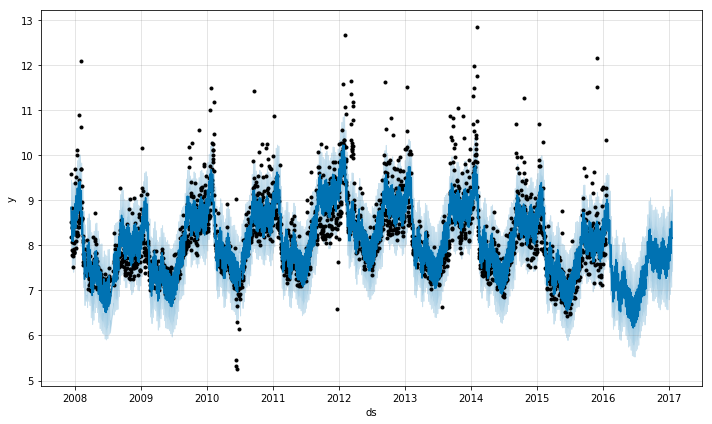

In [29]:
m.plot(forecast);

If you want to see the forecast components, you can use the `Prophet.plot_components` method.  By default you'll see the trend, yearly seasonality, and weekly seasonality of the time series.  If you include holidays, you'll see those here, too.

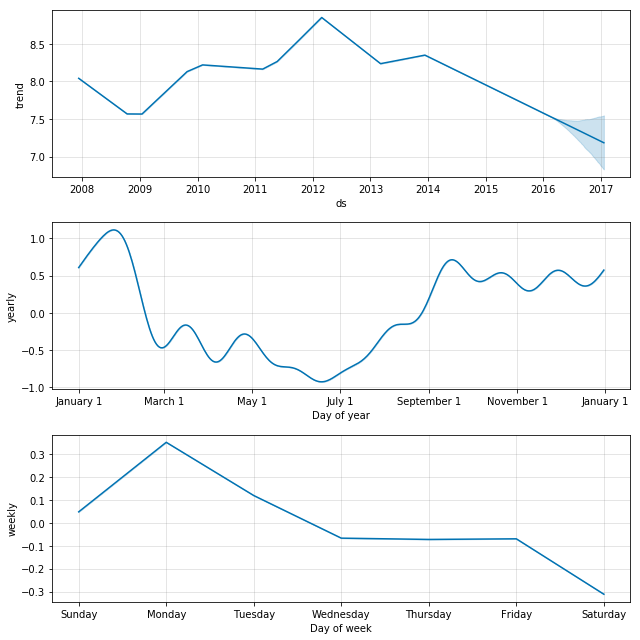

In [8]:
m.plot_components(forecast);

More details about the options available for each method are available in the docstrings, for example, via `help(Prophet)` or `help(Prophet.fit)`.

## R API

In R, we use the normal model fitting API.  We provide a `prophet` function that performs fitting and returns a model object.  You can then call `predict` and `plot` on this model object.

In [9]:
%%R
library(prophet)
library(dplyr)

First we read in the data and create the outcome variable. As in the Python API, this is a dataframe with columns `ds` and `y`, containing the date and numeric value respectively. As above, we use here the log number of views to Petyon Manning's Wikipedia page, available [here](https://github.com/facebookincubator/prophet/blob/master/examples/example_wp_peyton_manning.csv).

In [10]:
%%R
df <- read.csv('../examples/example_wp_peyton_manning.csv') %>%
  mutate(y = log(y))

We call the `prophet` function to fit the model.  The first argument is the historical dataframe.  Additional arguments control how Prophet fits the data and are described in later pages of this documentation.

In [11]:
%%R
m <- prophet(df)

Initial log joint probability = -19.4685
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Predictions are made on a dataframe with a column `ds` containing the dates for which predictions are to be made. The `make_future_dataframe` function takes the model object and a number of periods to forecast and produces a suitable dataframe. By default it will also include the historical dates so we can evaluate in-sample fit.

In [12]:
%%R
future <- make_future_dataframe(m, periods = 365)
tail(future)

             ds
3265 2017-01-14
3266 2017-01-15
3267 2017-01-16
3268 2017-01-17
3269 2017-01-18
3270 2017-01-19


As with most modeling procedures in R, we use the generic `predict` function to get our forecast. The `forecast` object is a dataframe with a column `yhat` containing the forecast. It has additional columns for uncertainty intervals and seasonal components.

In [13]:
%%R
forecast <- predict(m, future)
tail(forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')])

             ds     yhat yhat_lower yhat_upper
3265 2017-01-14 7.825609   7.183818   8.488012
3266 2017-01-15 8.207400   7.478778   8.951113
3267 2017-01-16 8.532394   7.826360   9.240482
3268 2017-01-17 8.319785   7.596815   9.042505
3269 2017-01-18 8.152424   7.440858   8.874581
3270 2017-01-19 8.164327   7.419148   8.882906


You can use the generic `plot` function to plot the forecast, by passing in the model and the forecast dataframe.

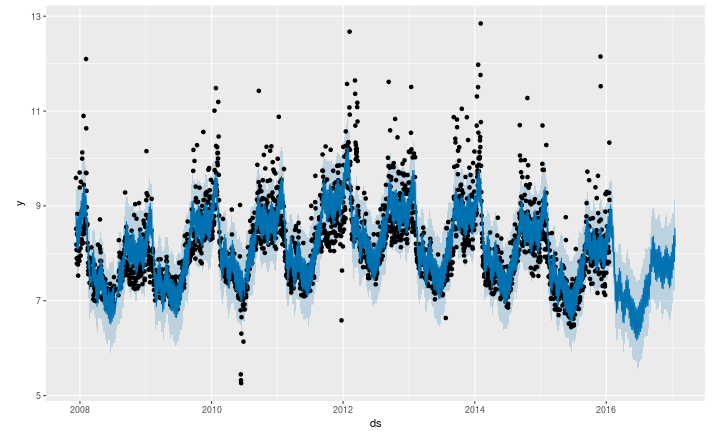

In [14]:
%%R -w 10 -h 6 -u in
plot(m, forecast)

You can use the `prophet_plot_components` function to see the forecast broken down into trend, weekly seasonality, and yearly seasonality.

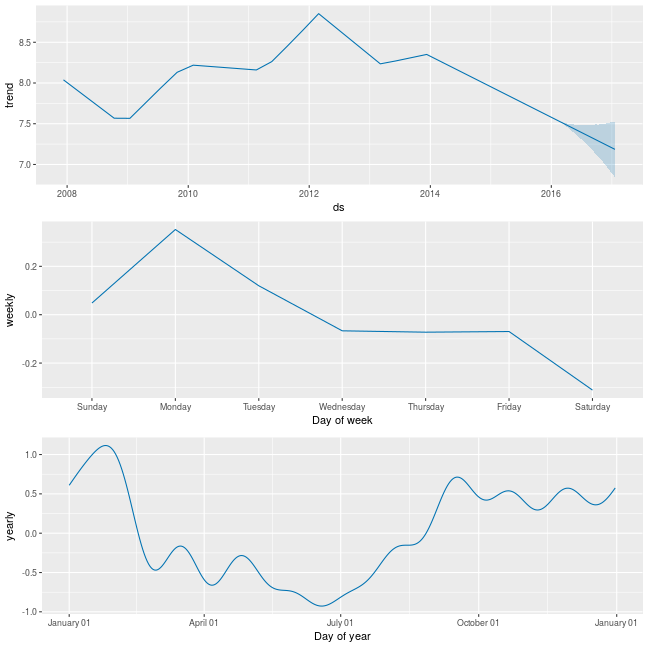

In [15]:
%%R -w 9 -h 9 -u in
prophet_plot_components(m, forecast)

More details about the options available for each method are available in the docstrings, for example, via `?prophet` or `?fit.prophet`. This documentation is also available in the [reference manual](https://cran.r-project.org/web/packages/prophet/prophet.pdf) on CRAN.